# Downloading, pre-processing and running cNMF on Zepp et. al 2021 data
1. Obtaining the AnnData object and complementary metadata
2. filtering genes, and showing key statistics
3. Subsetting and splitting the dataset by developmental stage, and selecting joint highly variable genes (HVG)
4. Running consensus NMF (cNMF) per stage
5. Selecting parameters for the cNMF
6. Running the comparator for adjacent steps



In [1]:
%%time
%load_ext autoreload
%autoreload 2

#debug:
from importlib import reload

import sys
import os
import time
import warnings

import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import scanpy as sc

sc.settings.n_jobs=-1

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf
from gepdynamics import comparator

_utils.cd_proj_home()
print(os.getcwd())



/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 5.61 s, sys: 2.39 s, total: 7.99 s
Wall time: 2min 50s


In [2]:
results_dir = _utils.set_dir('results')
results_dir = _utils.set_dir(results_dir.joinpath('zepp'))
data_dir = _utils.set_dir('data')
GSE_dir = _utils.set_dir(data_dir.joinpath('GSE149563'))

## 1. Obtaining the AnnData object and complementary metadata
The adata contains log1p(CP10K) data, we un-transform the data to have the original counts as `X`

In [3]:
%%script --no-raise-error false # remove this to run the downloading

# Adata downloaded from https://data-browser.lungmap.net/explore/projects/00f056f2-73ff-43ac-97ff-69ca10e38c89/get-curl-command
# by running this for the adata: 
!(cd {GSE_dir.as_posix()} && curl --location --fail 'https://service.azul.data.humancellatlas.org/manifest/files?catalog=lm3&format=curl&filters=%7B%22fileFormat%22%3A+%7B%22is%22%3A+%5B%22h5ad%22%5D%7D%2C+%22projectId%22%3A+%7B%22is%22%3A+%5B%2200f056f2-73ff-43ac-97ff-69ca10e38c89%22%5D%7D%2C+%22genusSpecies%22%3A+%7B%22is%22%3A+%5B%22Mus+musculus%22%5D%7D%7D&objectKey=manifests%2Fe42d976a-5137-5422-be32-39008e1d53d7.1ad7b2a4-0d0f-55d3-9d0c-6c37e8d46dc8.curlrc' | curl --config - )
# and then running this for the metadata: 
!(cd {GSE_dir.as_posix()} && curl --location --fail 'https://service.azul.data.humancellatlas.org/manifest/files?catalog=lm3&format=curl&filters=%7B%22fileFormat%22%3A+%7B%22is%22%3A+%5B%22csv%22%5D%7D%2C+%22projectId%22%3A+%7B%22is%22%3A+%5B%2200f056f2-73ff-43ac-97ff-69ca10e38c89%22%5D%7D%2C+%22genusSpecies%22%3A+%7B%22is%22%3A+%5B%22Mus+musculus%22%5D%7D%7D&objectKey=manifests%2Fed538a08-689b-530d-a661-e1756132b883.1ad7b2a4-0d0f-55d3-9d0c-6c37e8d46dc8.curlrc' | curl --config -)

download_dir = GSE_dir.joinpath('a078a6cb-a72a-305c-80df-cf35aedd01ff')
! mv {download_dir.as_posix()}/* {GSE_dir.as_posix()}
! rmdir {download_dir.as_posix()}

In [4]:
%%time

%time adata = sc.read_h5ad(GSE_dir.joinpath('JZ_Mouse_TimeSeries.h5ad'))
metadata = pd.read_csv(GSE_dir.joinpath('AllTimePoints_metadata.csv'), index_col=0)

adata.obs['celltype'] = metadata.var_celltype
adata.obs['compartment'] = metadata.var_compartment

untransformed = sparse.csr_matrix(adata.obs.n_molecules.values[:, None].astype(np.float32) / 10_000).multiply(adata.X.expm1())
adata.X = sparse.csr_matrix(untransformed).rint()

del untransformed, metadata

adata

CPU times: user 9.06 s, sys: 731 ms, total: 9.8 s
Wall time: 14.4 s
CPU times: user 19.7 s, sys: 1.84 s, total: 21.5 s
Wall time: 26.4 s


AnnData object with n_obs × n_vars = 67794 × 18129
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment'
    var: 'name'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [5]:
adata.obs.development_stage = adata.obs.development_stage.cat.rename_categories(
    {'Adult': 'P42', 'E12.5': 'E12', 'E15.5': 'E15', 'E17.5': 'E17'}).cat.reorder_categories(
    ['E12', 'E15', 'E17', 'P3', 'P7', 'P15', 'P42'])

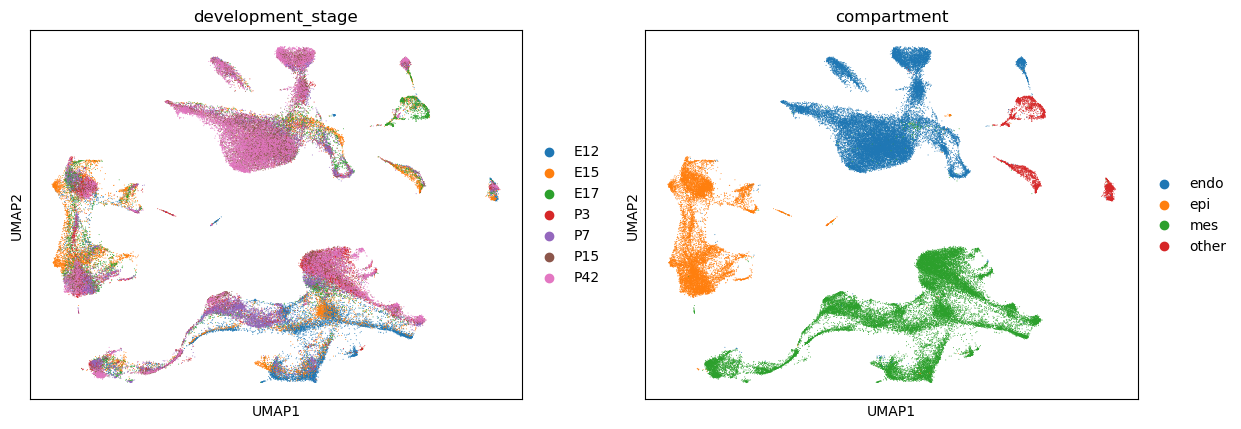

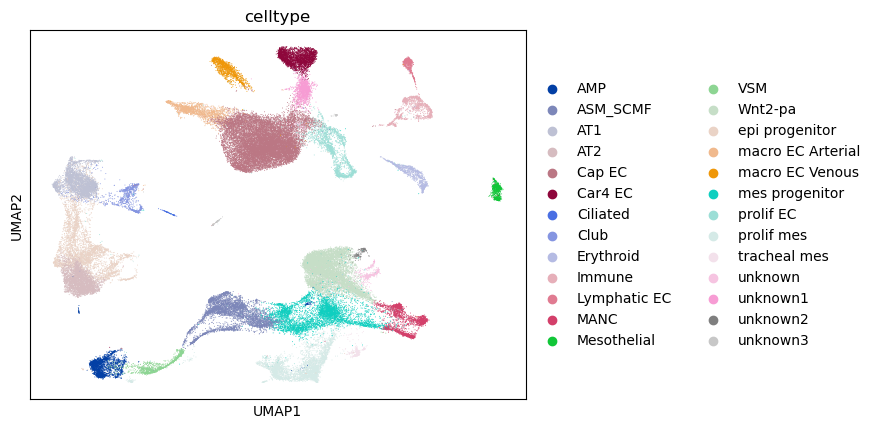

In [6]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.pl.umap(adata, color=['development_stage', 'compartment'])
    sc.pl.umap(adata, color=['celltype'])

adata.uns['development_stage_colors_dict'] = dict(zip(adata.obs['development_stage'].cat.categories, adata.uns['development_stage_colors']))
adata.uns['compartment_colors_dict'] = dict(zip(adata.obs['compartment'].cat.categories, adata.uns['compartment_colors']))
adata.uns['celltype_colors_dict'] = dict(zip(adata.obs['celltype'].cat.categories, adata.uns['celltype_colors']))

In [7]:
pd.crosstab(adata.obs.development_stage, adata.obs.compartment)

compartment        endo   epi   mes  other
development_stage                         
E12                 133   679  7752    403
E15                1095  3676  2516   1017
E17                1681  2573  2012    937
P3                 2991  2196  5063    141
P7                 3992  1632  4433    140
P15                7345   739  2327    108
P42                7646  1041  3404    122

In [8]:
pd.crosstab(adata.obs.celltype, adata.obs.development_stage)

development_stage   E12   E15  E17    P3    P7   P15   P42
celltype                                                  
AMP                 178   224  317   327   356   189   376
ASM_SCMF            732   227  417   678  1936   378   263
AT1                 125   711  779   865   344   248   355
AT2                  54   243  739   815   811   432   517
Cap EC               55   557  783  1517  2073  5239  4875
Car4 EC               0     0   30   346   430   908  1078
Ciliated              0     0    5    61     5     2     4
Club                112   418  157    94    72    26    54
Erythroid            53   601  114    18    70    65     7
Immune              117   278  764     7     5    21    49
Lymphatic EC         14    62   66    92    72   108   169
MANC                740    86   82   315   244   202   419
Mesothelial         233   138   59   116    65    22    66
VSM                  74    66   95   233   279   244   205
Wnt2-pa              53    90  811  3183   959  1207  1701
epi progenitor      291  2300  890   350   388    27   105
macro EC Arterial     0    19   91   254   254   402   661
macro EC Venous       1    38   64   176   268   283   451
mes progenitor     3216  1097  161    83   312     5    34
prolif EC            60   416  556   302   665    36    30
prolif mes         2509   713  103    83   295     7     2
tracheal mes        248     6    3    42     1     3     1
unknown               2     7   23   119    43    83   276
unknown1              3     3   91   304   230   369   382
unknown2              0     0    0     0     8     9   127
unknown3             97     4    3    11    12     4     6

In [9]:
pd.crosstab(adata.obs.celltype, adata.obs.compartment)

compartment         endo   epi   mes  other
celltype                                   
AMP                    0     0  1967      0
ASM_SCMF               0     0  4631      0
AT1                    0  3427     0      0
AT2                    0  3611     0      0
Cap EC             15099     0     0      0
Car4 EC             2792     0     0      0
Ciliated               0    77     0      0
Club                   0   933     0      0
Erythroid              0     0     0    928
Immune                 0     0     0   1241
Lymphatic EC         583     0     0      0
MANC                   0     0  2088      0
Mesothelial            0     0     0    699
VSM                    0     0  1196      0
Wnt2-pa                0     0  8004      0
epi progenitor         0  4351     0      0
macro EC Arterial   1681     0     0      0
macro EC Venous     1281     0     0      0
mes progenitor         0     0  4908      0
prolif EC           2065     0     0      0
prolif mes             0     0  3712      0
tracheal mes           0     0   304      0
unknown                0     0   553      0
unknown1            1382     0     0      0
unknown2               0     0   144      0
unknown3               0   137     0      0

13 mitochondrial genes


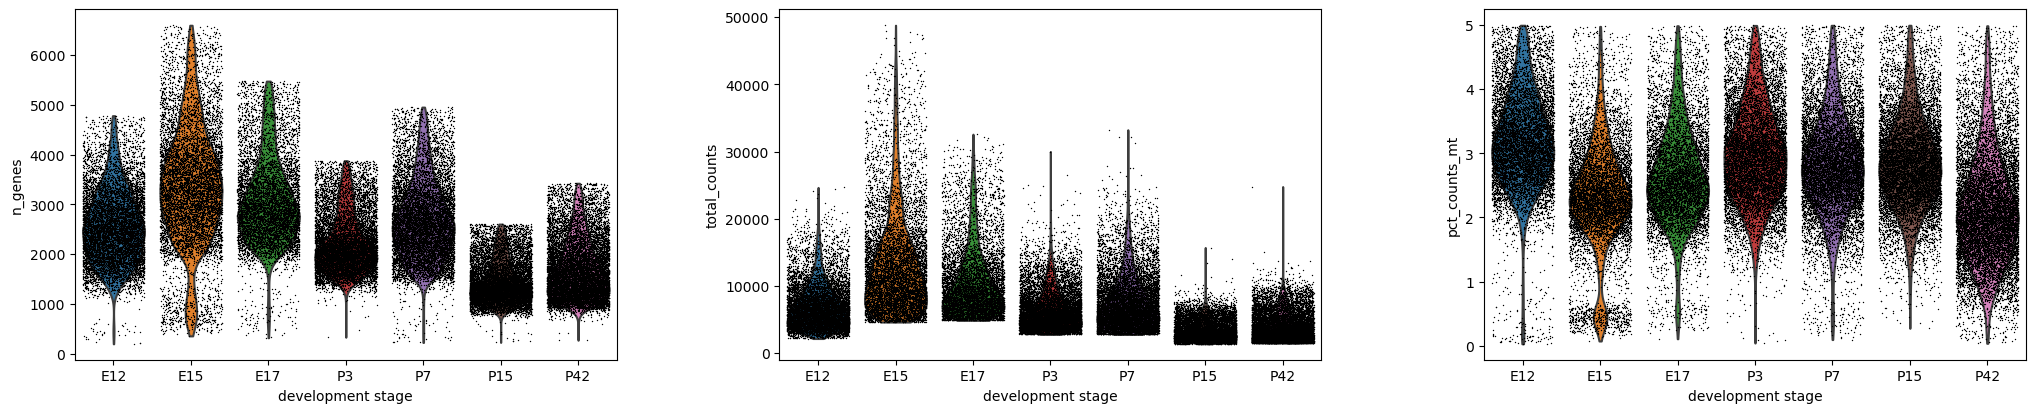

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
print(f"{np.sum(adata.var['mt'])} mitochondrial genes")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt',],
                 jitter=0.4, multi_panel=True, groupby='development_stage')

## 2. filtering genes, selecting joint highly variable genes (HVGs) and showing key statistics


In [11]:
%%time
print(f'before filtering shape was {adata.X.shape}')

# filtering cells with low number of genes
sc.pp.filter_cells(adata, min_genes=500)

# filtering genes with very low abundance
sc.pp.filter_genes(adata, min_cells=np.round(adata.shape[0] / 2000))

# getting general statistics for counts abundance
sc.pp.filter_genes(adata, min_counts=0)
sc.pp.filter_cells(adata, min_counts=0)


sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)

print(f'after filtering shape is {adata.X.shape}')

adata

before filtering shape was (67794, 18129)
after filtering shape is (67684, 16964)
CPU times: user 12.2 s, sys: 4.68 s, total: 16.9 s
Wall time: 22.5 s


AnnData object with n_obs × n_vars = 67684 × 16964
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'development_stage_colors', 'compartment_colors', 'celltype_colors', 'development_stage_colors_dict', 'compartment_colors_dict', 'celltype_colors_dict', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

/tmp/ipykernel_750450/991867812.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
/tmp/ipykernel_750450/991867812.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],


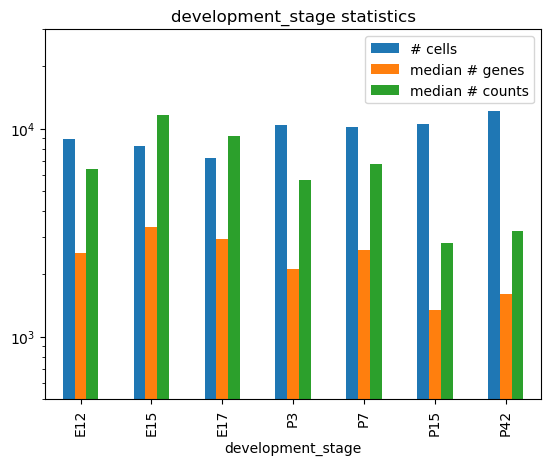

In [12]:
column_of_interest = 'development_stage'

stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((5e2, 3e4)))
plt.show()
del column_of_interest, stats_df

In [13]:
_utils.joint_hvg_across_stages(adata, obs_category_key='development_stage', n_top_genes=5000)
adata.var

name     mt  n_cells_by_counts  mean_counts  \
Sox17                  Sox17  False              18167     0.612783   
Mrpl15                Mrpl15  False              22890     0.537894   
Lypla1                Lypla1  False              18216     0.339838   
Tcea1                  Tcea1  False              29410     0.663849   
Atp6v1h              Atp6v1h  False              13201     0.226878   
...                      ...    ...                ...          ...   
6430584L05Rik  6430584L05Rik  False                 36     0.000546   
Platr31              Platr31  False                 56     0.000944   
Ido1                    Ido1  False                 80     0.001195   
Fetub                  Fetub  False                 49     0.000915   
Csprs                  Csprs  False                160     0.002478   

               pct_dropout_by_counts  total_counts  n_cells  n_counts  \
Sox17                      73.202643       41543.0    18163   41539.0   
Mrpl15                     66.235950       36466.0    22885   36461.0   
Lypla1                     73.130366       23039.0    18215   23038.0   
Tcea1                      56.618580       45005.0    29406   45001.0   
Atp6v1h                    80.527775       15381.0    13198   15378.0   
...                              ...           ...      ...       ...   
6430584L05Rik              99.946898          37.0       36      37.0   
Platr31                    99.917397          64.0       56      64.0   
Ido1                       99.881995          81.0       80      81.0   
Fetub                      99.927722          62.0       49      62.0   
Csprs                      99.763991         168.0      160     168.0   

               highly_variable  highly_variable_rank     means  variances  \
Sox17                     True                1009.0  0.613720   2.188758   
Mrpl15                   False                   NaN  0.538695   0.940024   
Lypla1                   False                   NaN  0.340376   0.401259   
Tcea1                    False                   NaN  0.664869   0.907306   
Atp6v1h                  False                   NaN  0.227203   0.249872   
...                        ...                   ...       ...        ...   
6430584L05Rik            False                   NaN  0.000547   0.000576   
Platr31                  False                   NaN  0.000946   0.001211   
Ido1                     False                   NaN  0.001197   0.001225   
Fetub                     True                1633.0  0.000916   0.001477   
Csprs                    False                   NaN  0.002482   0.002712   

               variances_norm  development_stage_max_var_norm  \
Sox17                1.910590                        6.761547   
Mrpl15               0.987096                        0.987096   
Lypla1               0.775744                        0.927777   
Tcea1                0.705466                        0.917639   
Atp6v1h              0.793361                        0.928535   
...                       ...                             ...   
6430584L05Rik        0.998808                        0.998808   
Platr31              1.142795                        1.142795   
Ido1                 0.892949                        0.892949   
Fetub                1.443468                        1.443468   
Csprs                0.897597                        0.940303   

               joint_highly_variable  
Sox17                           True  
Mrpl15                         False  
Lypla1                         False  
Tcea1                          False  
Atp6v1h                        False  
...                              ...  
6430584L05Rik                  False  
Platr31                         True  
Ido1                           False  
Fetub                           True  
Csprs                          False  

[16964 rows x 15 columns]

## Cleaning the data - doublet removal and bad classifications

### Training VAE towards Solo doublet removal

In [14]:
import torch
torch.set_float32_matmul_precision("high")

In [15]:
%%time
import scvi
from lightning.fabric.utilities.warnings import PossibleUserWarning
warnings.filterwarnings("ignore", category=PossibleUserWarning)

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


CPU times: user 3.78 s, sys: 918 ms, total: 4.7 s
Wall time: 1min 51s


In [16]:
%%time
subdata = adata[:, adata.var.joint_highly_variable].copy()
#scvi.model.SCVI.setup_anndata(subdata, batch_key='development_stage')
#vae = scvi.model.SCVI(subdata, n_layers=3, n_hidden=256, n_latent=64, dispersion='gene-batch')

scvi.model.SCVI.setup_anndata(subdata, labels_key='development_stage')
vae = scvi.model.SCVI(subdata, n_layers=3, n_hidden=256, n_latent=64, dispersion='gene-label')

vae

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


CPU times: user 1.28 s, sys: 373 ms, total: 1.66 s
Wall time: 1.71 s


SCVI Model with the following params: 
n_hidden: 256, n_latent: 64, n_layers: 3, dropout_rate: 0.1, dispersion: gene-label, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [25]:
%time vae.train(accelerator='gpu', train_size=0.8, validation_size=0.1, batch_size=128, max_epochs=200)
%time vae.train(accelerator='gpu', train_size=0.8, validation_size=0.1, batch_size=512, max_epochs=200)
%time vae.train(accelerator='gpu', train_size=0.8, validation_size=0.1, batch_size=256, max_epochs=200)
vae

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [19:15<00:00,  6.04s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=1.69e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [19:15<00:00,  5.78s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=1.69e+3]
CPU times: user 22min 5s, sys: 4min 20s, total: 26min 25s
Wall time: 19min 16s


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [07:07<00:00,  2.13s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.68e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [07:07<00:00,  2.14s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.68e+3]
CPU times: user 10min 10s, sys: 4min 23s, total: 14min 34s
Wall time: 7min 7s


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [11:02<00:00,  3.40s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.68e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [11:02<00:00,  3.31s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.68e+3]
CPU times: user 13min 59s, sys: 4min 20s, total: 18min 19s
Wall time: 11min 3s


SCVI Model with the following params: 
n_hidden: 256, n_latent: 64, n_layers: 3, dropout_rate: 0.1, dispersion: gene-label, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [141]:
vae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

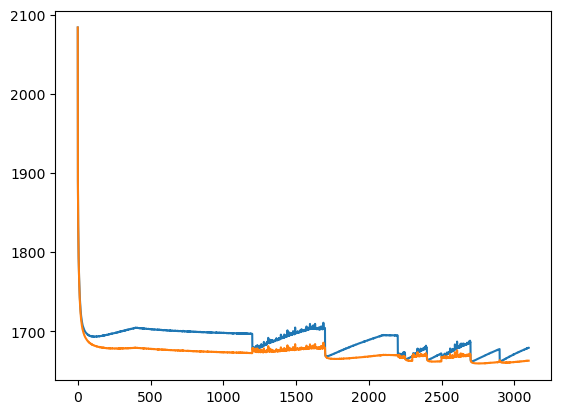

In [26]:
plt.plot(vae.history['train_loss_epoch'])
plt.plot(vae.history['reconstruction_loss_train'])

In [27]:
# model_dir = results_dir.joinpath("scvi_model_batches")
model_dir = results_dir.joinpath("scvi_model_labels")

if vae.is_trained:
    vae.save(model_dir, overwrite=True)

# vae = scvi.model.SCVI.load(model_dir, adata=adata[:, adata.var.joint_highly_variable].copy())
vae

SCVI Model with the following params: 
n_hidden: 256, n_latent: 64, n_layers: 3, dropout_rate: 0.1, dispersion: gene-label, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [28]:
SCVI_LATENT_KEY = "X_scVI"

latent = vae.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(67684, 64)

Visualizing the SCVI latent space

In [29]:
%%time
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
vae_adata = sc.tl.umap(adata, min_dist=0.3, copy=True)

CPU times: user 1min 52s, sys: 18.3 s, total: 2min 11s
Wall time: 1min 18s


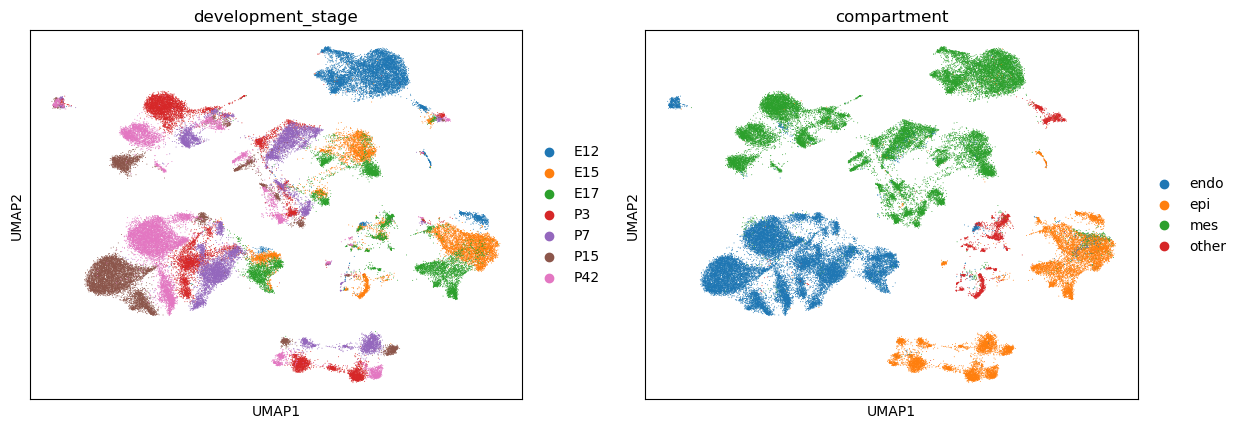

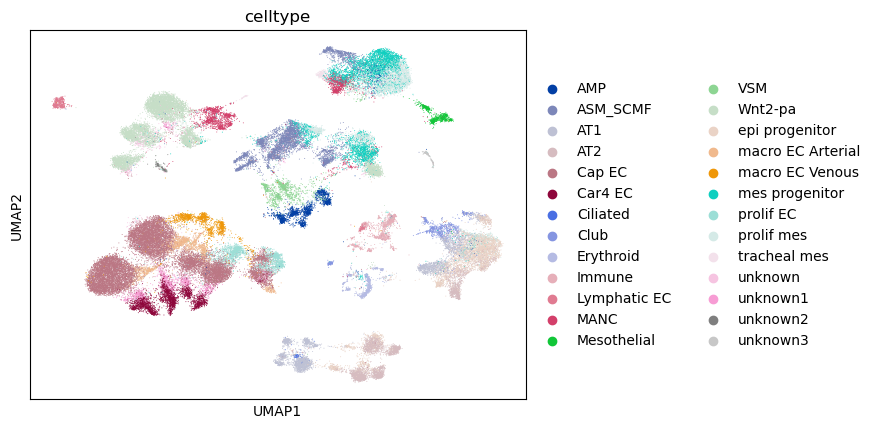

In [30]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sc.pl.umap(vae_adata, color=['development_stage', 'compartment'])
    sc.pl.umap(vae_adata, color=['celltype'])

### Solo doublet prediction

In [31]:
stages = adata.obs.development_stage.cat.categories
stages

Index(['E12', 'E15', 'E17', 'P3', 'P7', 'P15', 'P42'], dtype='object')

In [32]:
adata.obs['doublet_softmax'] = np.nan

working on stage E12
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 64/600:  11%|█         | 64/600 [05:10<43:23,  4.86s/it, v_num=1, train_loss_step=0.0488, train_loss_epoch=0.041]  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.043. Signaling Trainer to stop.
CPU times: user 6min 36s, sys: 2min 13s, total: 8min 49s
Wall time: 5min 11s
Epoch 31/600:   5%|▌         | 31/600 [01:16<23:32,  2.48s/it, v_num=1, train_loss_step=0.0141, train_loss_epoch=0.0374]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.032. Signaling Trainer to stop.
CPU times: user 2min, sys: 1min 4s, total: 3min 4s
Wall time: 1min 17s
prediction
singlet    8362
doublet     582
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              11      122
epi               54      625
mes              477     7275
other             40      340
prediction      doublet  singlet
celltype                        
AT1                  13      112
AT2                   4       50
Club                  8      104
epi progenitor       25      266
unknown3              4       93


/tmp/ipykernel_750450/553240500.py:29: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dat.obs['softmax'] = df.softmax


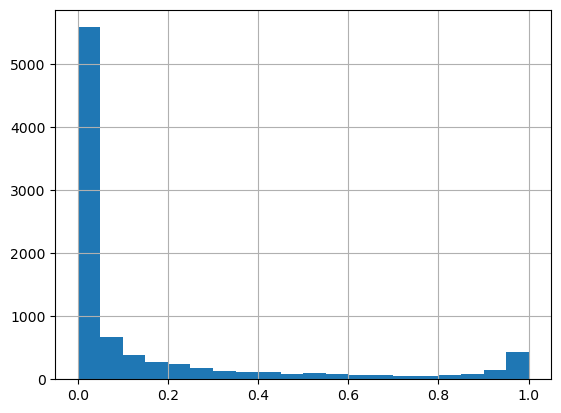

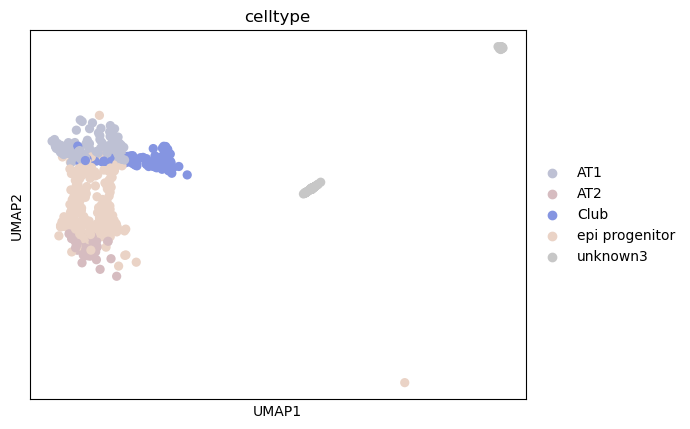

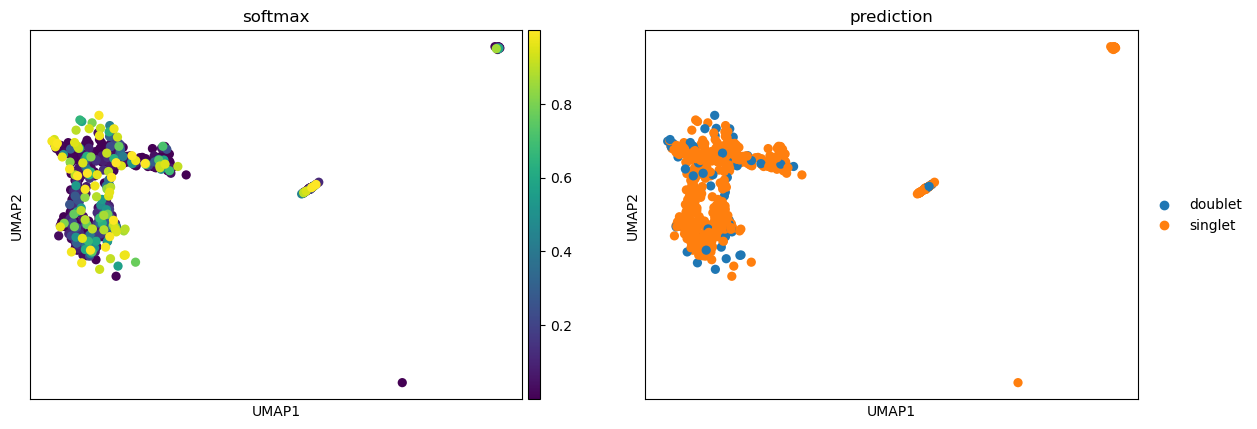

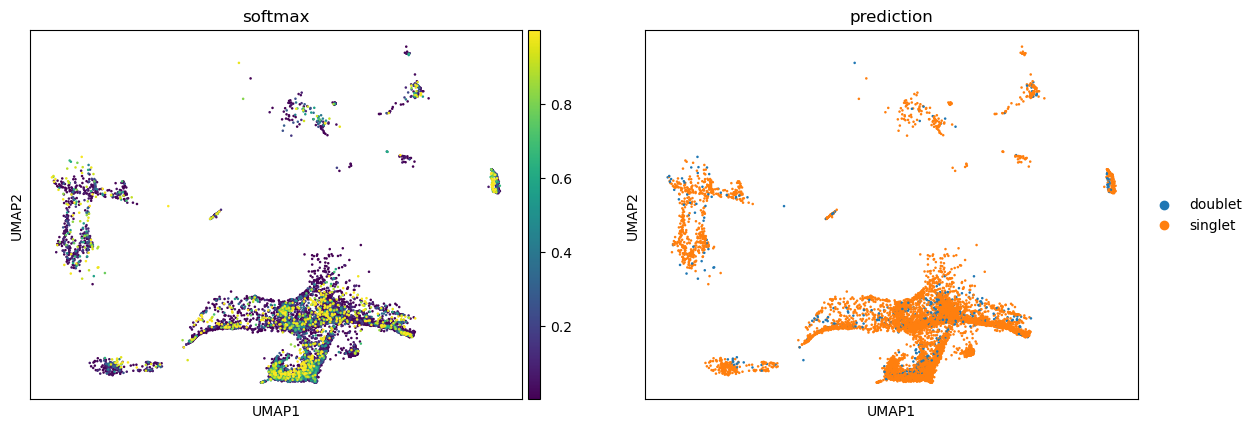

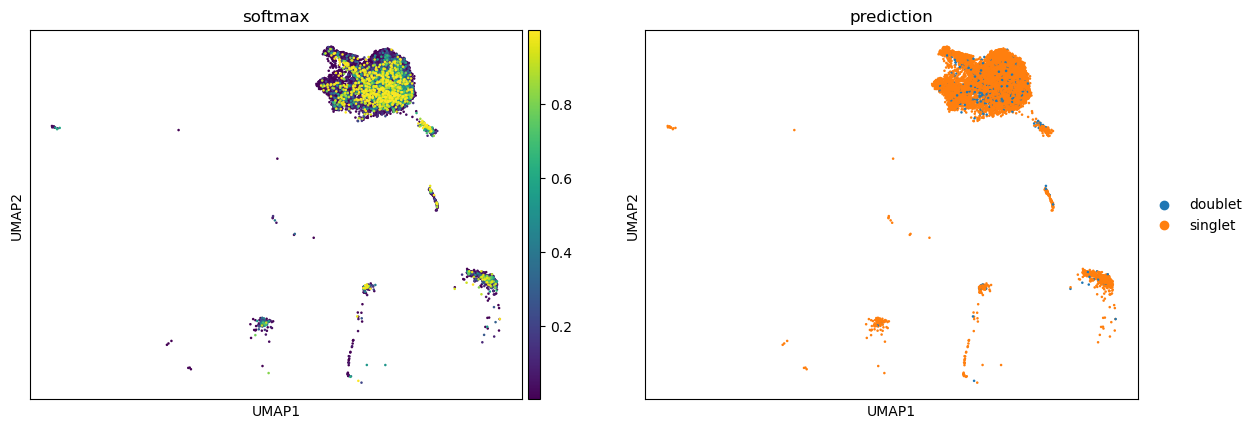

working on stage E15
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 63/600:  10%|█         | 63/600 [04:41<40:03,  4.47s/it, v_num=1, train_loss_step=0.00606, train_loss_epoch=0.0458]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.054. Signaling Trainer to stop.
CPU times: user 6min 7s, sys: 2min 10s, total: 8min 17s
Wall time: 4min 42s
Epoch 31/600:   5%|▌         | 31/600 [01:11<21:46,  2.30s/it, v_num=1, train_loss_step=0.00835, train_loss_epoch=0.0428]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.043. Signaling Trainer to stop.
CPU times: user 1min 54s, sys: 1min 3s, total: 2min 58s
Wall time: 1min 11s
prediction
singlet    7665
doublet     610
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              95     1000
epi              342     3334
mes              131     2385
other             42      946


/tmp/ipykernel_750450/553240500.py:29: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dat.obs['softmax'] = df.softmax


prediction      doublet  singlet
celltype                        
AT1                  81      630
AT2                   1      242
Club                 34      384
epi progenitor      226     2074
unknown3              0        4


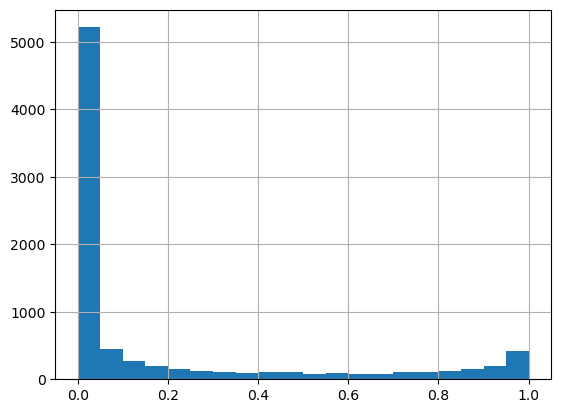

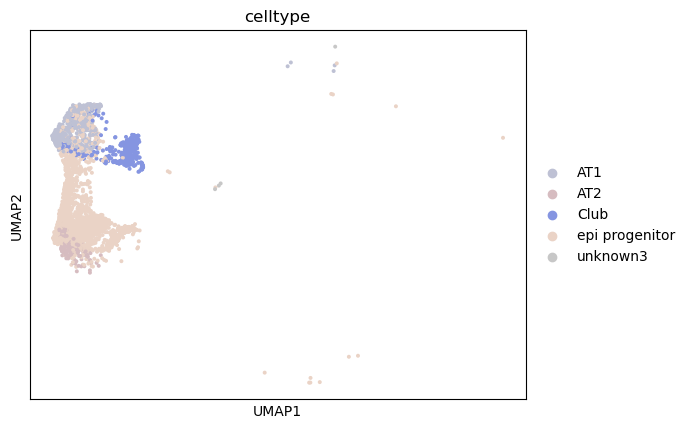

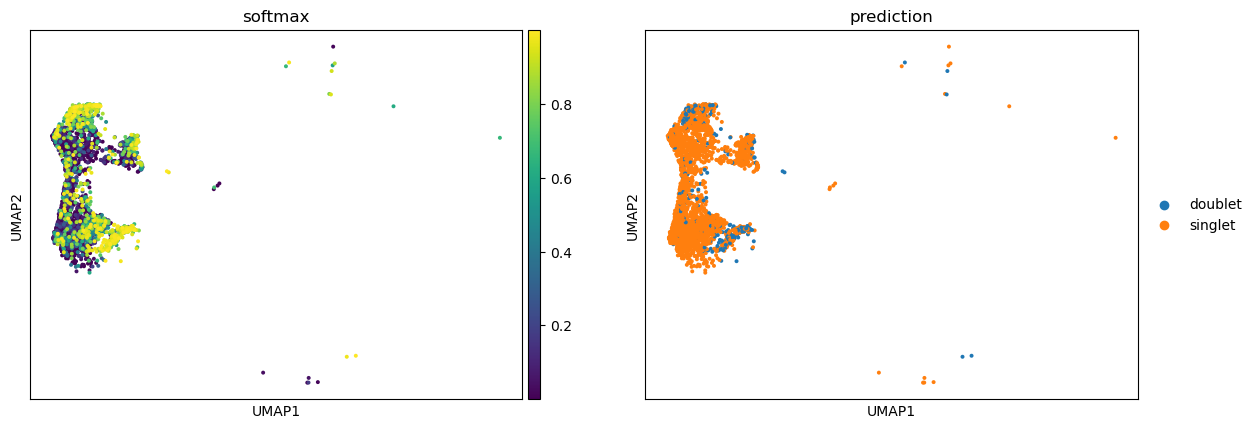

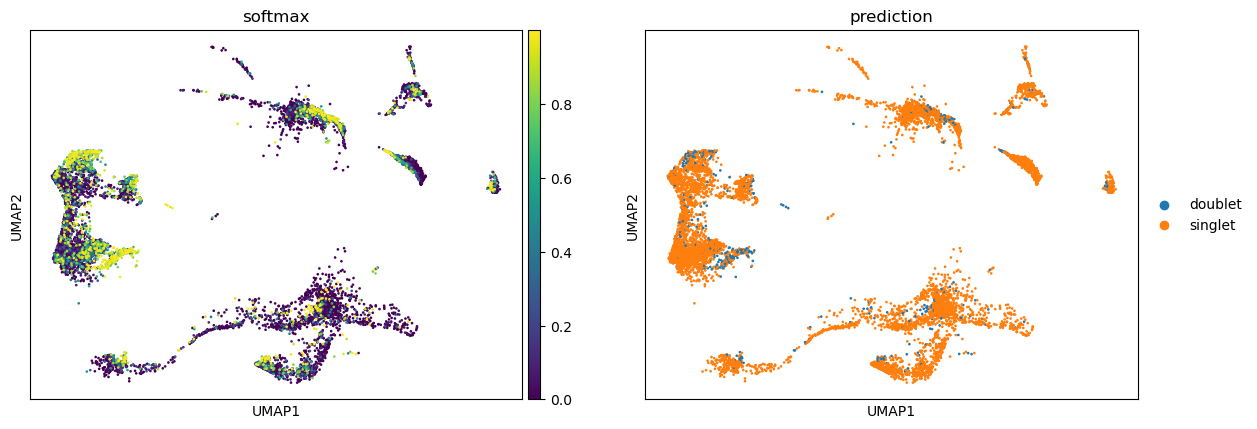

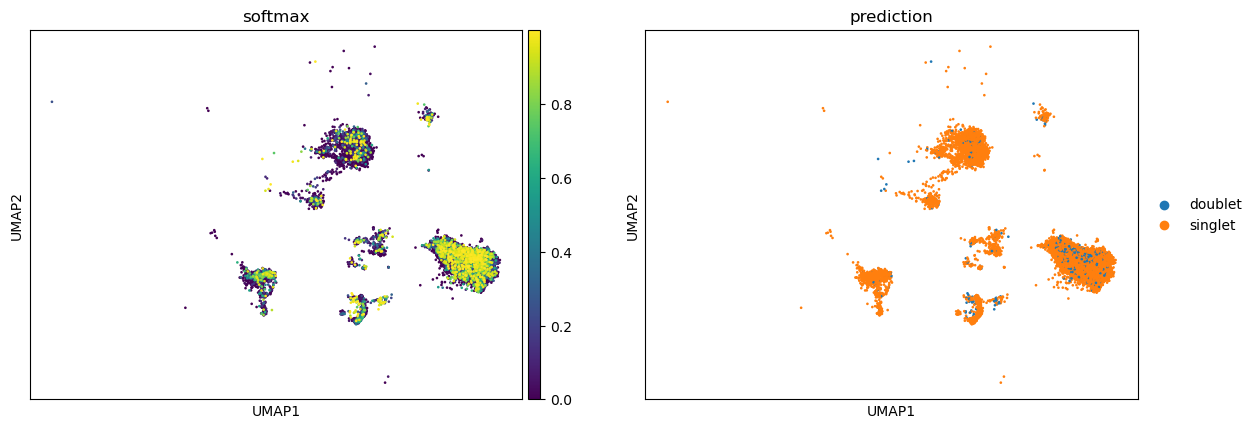

working on stage E17
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 111/600:  18%|█▊        | 111/600 [07:03<31:04,  3.81s/it, v_num=1, train_loss_step=0.0315, train_loss_epoch=0.038]  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.045. Signaling Trainer to stop.
CPU times: user 9min 35s, sys: 3min 49s, total: 13min 25s
Wall time: 7min 3s
Epoch 31/600:   5%|▌         | 31/600 [01:01<18:57,  2.00s/it, v_num=1, train_loss_step=0.0116, train_loss_epoch=0.034]  
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.036. Signaling Trainer to stop.
CPU times: user 1min 45s, sys: 1min 3s, total: 2min 49s
Wall time: 1min 2s
prediction
singlet    6797
doublet     395
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              95     1586
epi              209     2364
mes               70     1942
other             21      905
prediction      doublet  singlet
celltype                        
AT1                  44      735
AT2                   4      735
Ciliated              2        3
Club                  5      152
epi progenitor      154      736
unknown

/tmp/ipykernel_750450/553240500.py:29: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dat.obs['softmax'] = df.softmax


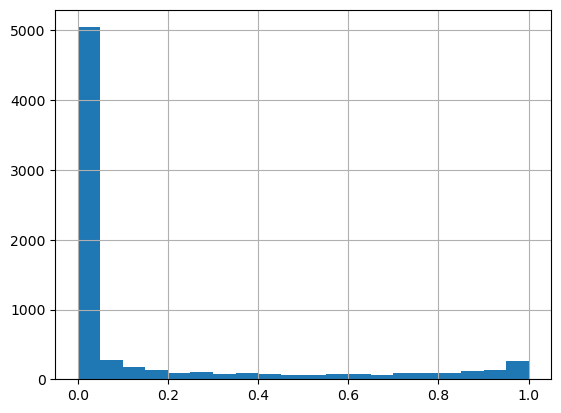

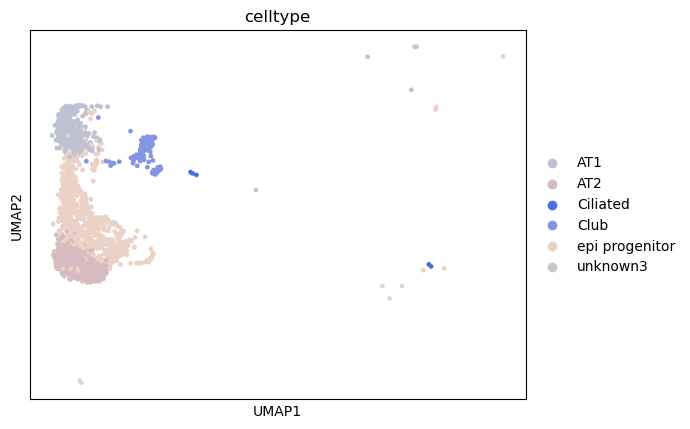

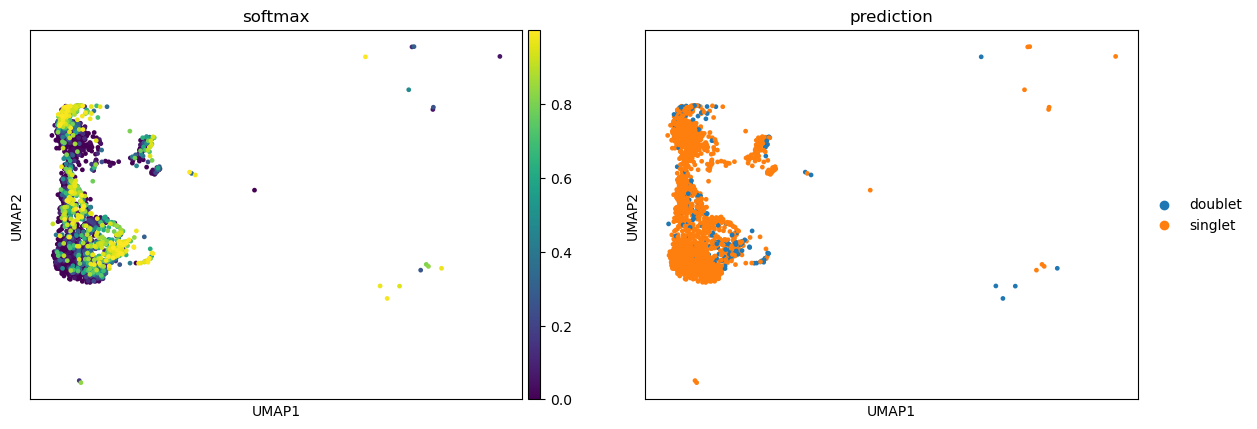

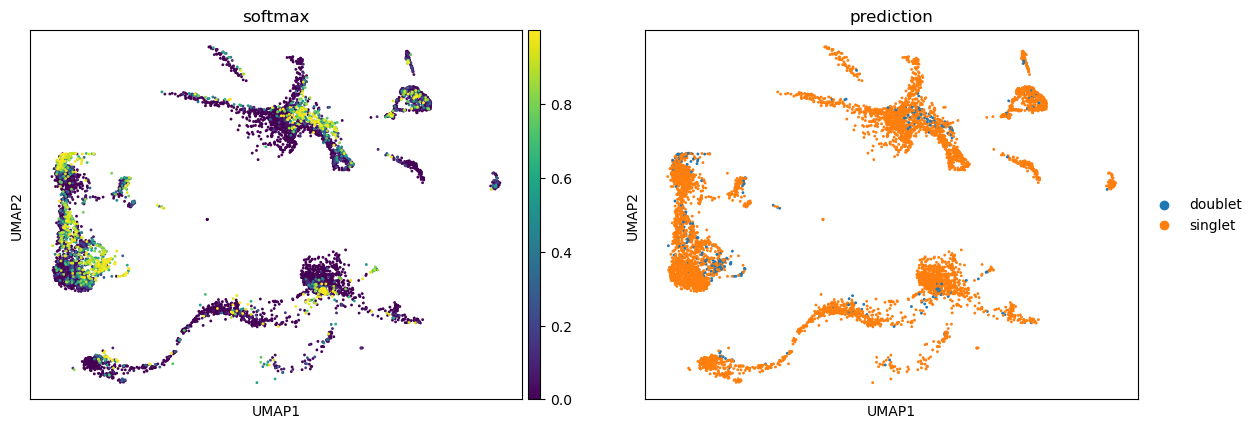

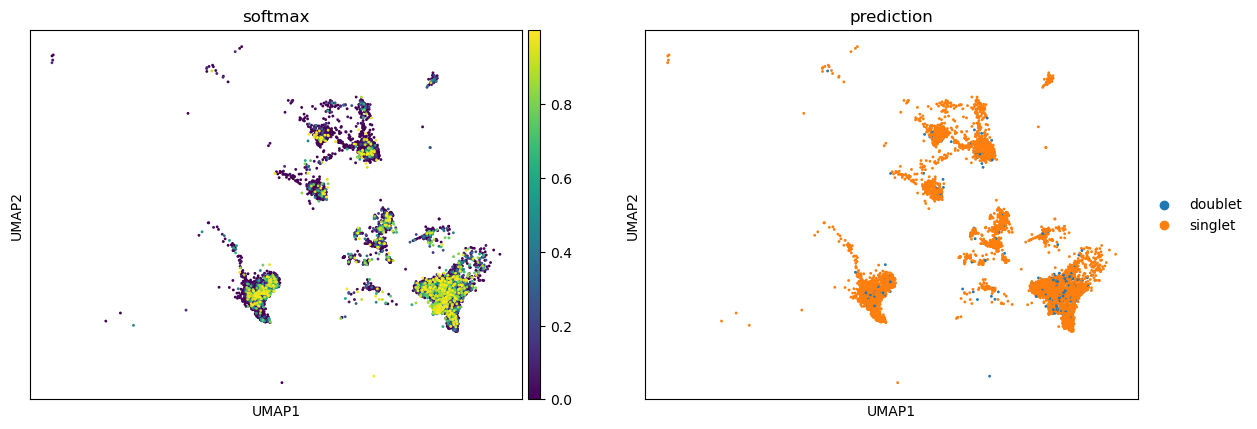

working on stage P3
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 59/600:  10%|▉         | 59/600 [05:38<51:43,  5.74s/it, v_num=1, train_loss_step=0.0661, train_loss_epoch=0.0426] 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.049. Signaling Trainer to stop.
CPU times: user 6min 56s, sys: 2min 2s, total: 8min 59s
Wall time: 5min 38s
Epoch 32/600:   5%|▌         | 32/600 [01:30<26:42,  2.82s/it, v_num=1, train_loss_step=0.0696, train_loss_epoch=0.0396]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.036. Signaling Trainer to stop.
CPU times: user 2min 14s, sys: 1min 6s, total: 3min 21s
Wall time: 1min 30s
prediction
singlet    9438
doublet     951
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo             269     2722
epi              351     1845
mes              323     4740
other              8      131
prediction      doublet  singlet
celltype                        
AT1                  82      783
AT2                  33      782
Ciliated             47       14
Club                  8       86
epi progenitor      181      169
unknown3

/tmp/ipykernel_750450/553240500.py:29: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dat.obs['softmax'] = df.softmax


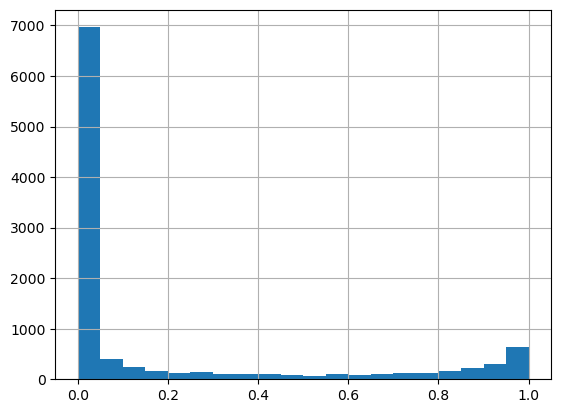

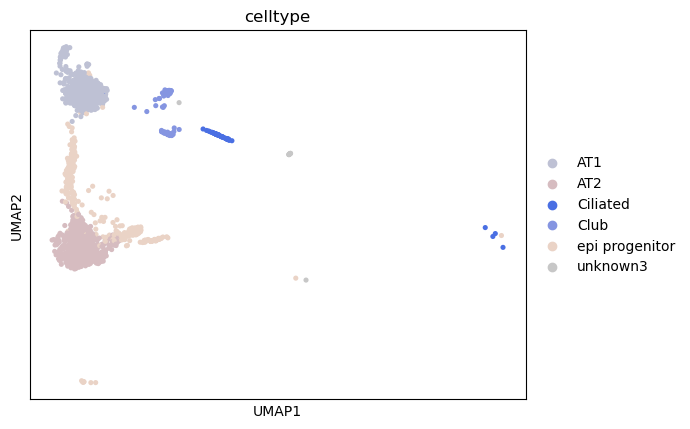

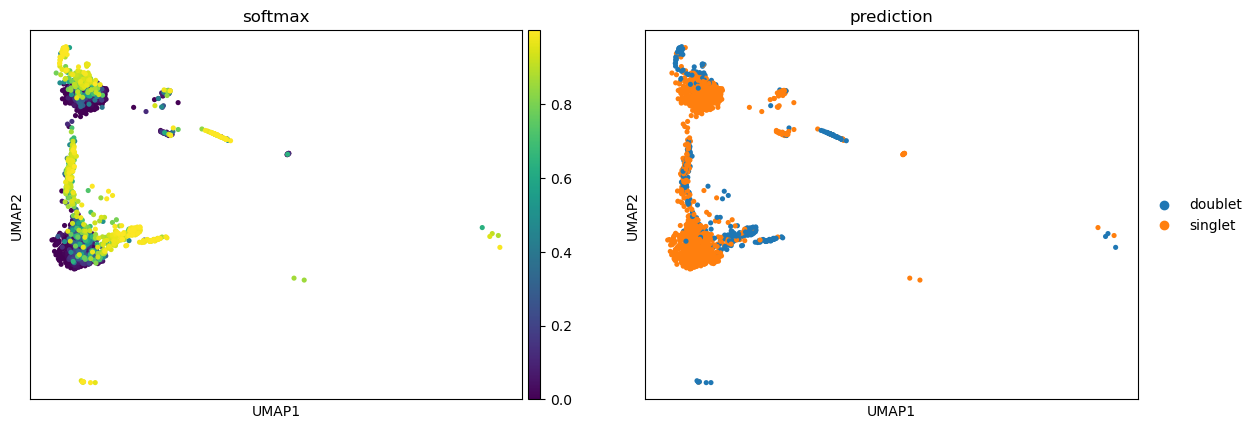

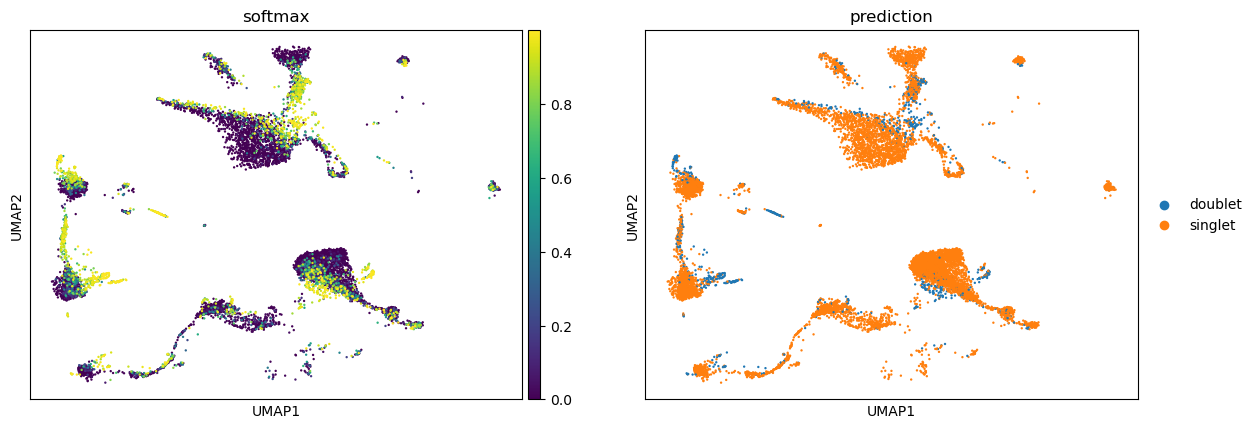

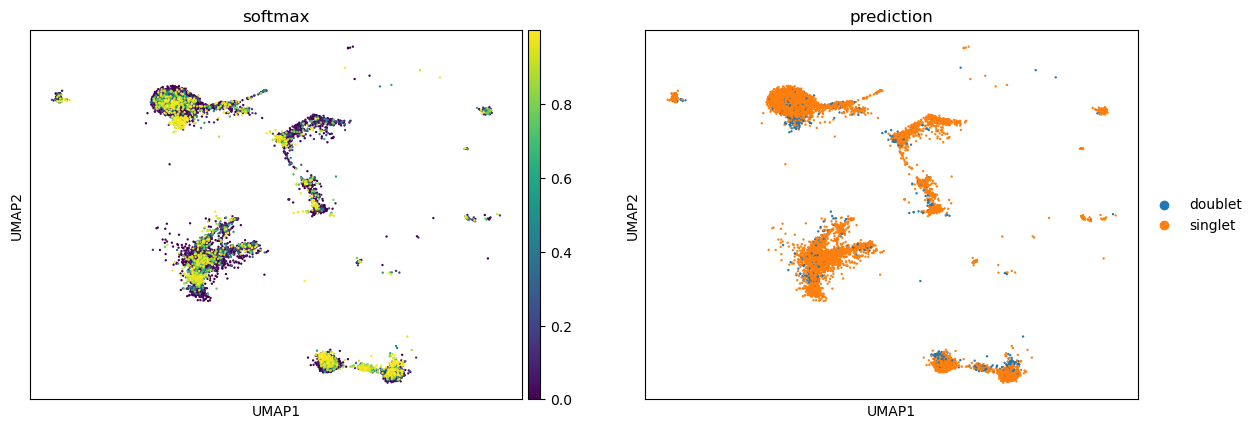

working on stage P7
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 121/600:  20%|██        | 121/600 [11:24<45:09,  5.66s/it, v_num=1, train_loss_step=0.128, train_loss_epoch=0.0439]  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.053. Signaling Trainer to stop.
CPU times: user 14min 4s, sys: 4min 11s, total: 18min 16s
Wall time: 11min 24s
Epoch 31/600:   5%|▌         | 31/600 [01:26<26:20,  2.78s/it, v_num=1, train_loss_step=0.0565, train_loss_epoch=0.0416] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.037. Signaling Trainer to stop.
CPU times: user 2min 9s, sys: 1min 3s, total: 3min 13s
Wall time: 1min 26s
prediction
singlet    9472
doublet     700
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo             330     3662
epi              143     1489
mes              220     4213
other              7      108


/tmp/ipykernel_750450/553240500.py:29: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dat.obs['softmax'] = df.softmax


prediction      doublet  singlet
celltype                        
AT1                  27      317
AT2                   6      805
Ciliated              2        3
Club                  2       70
epi progenitor      106      282
unknown3              0       12


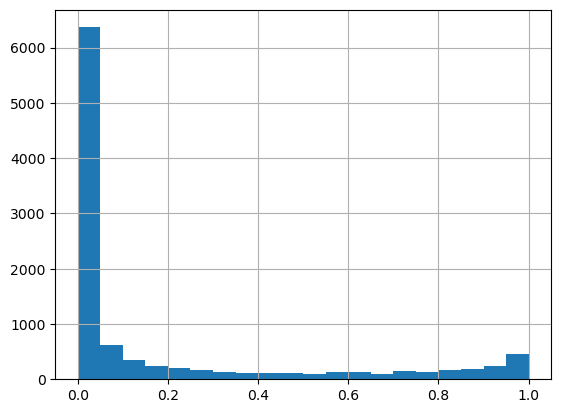

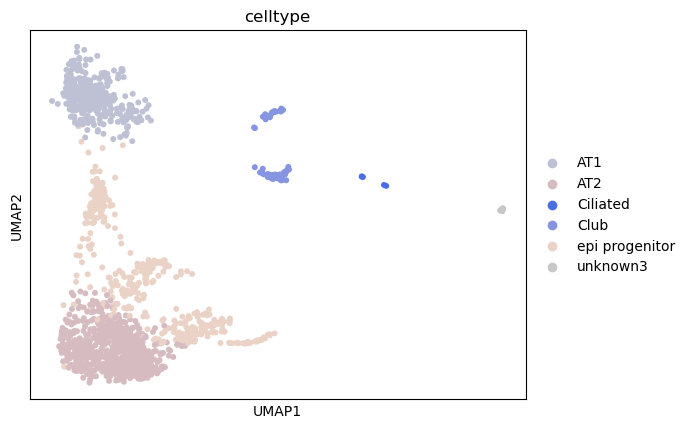

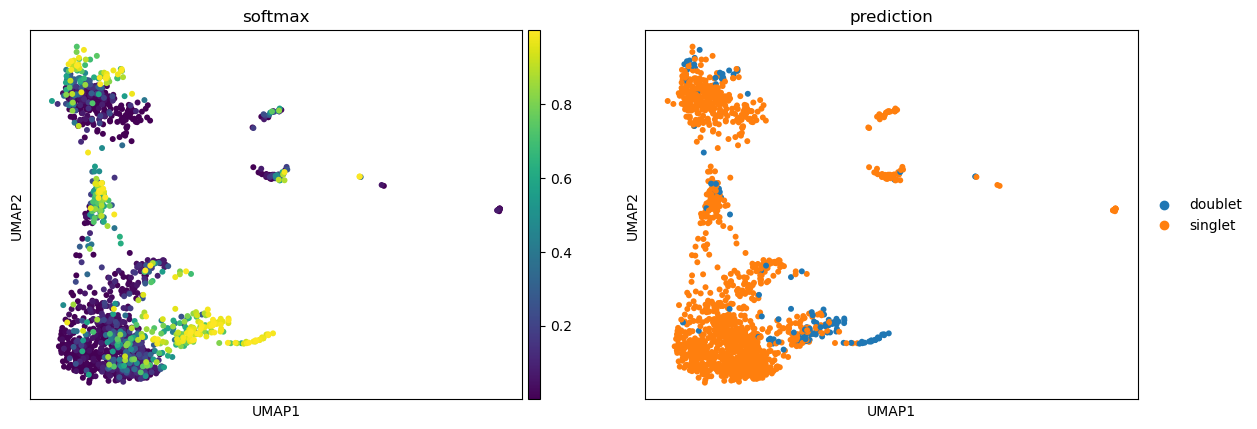

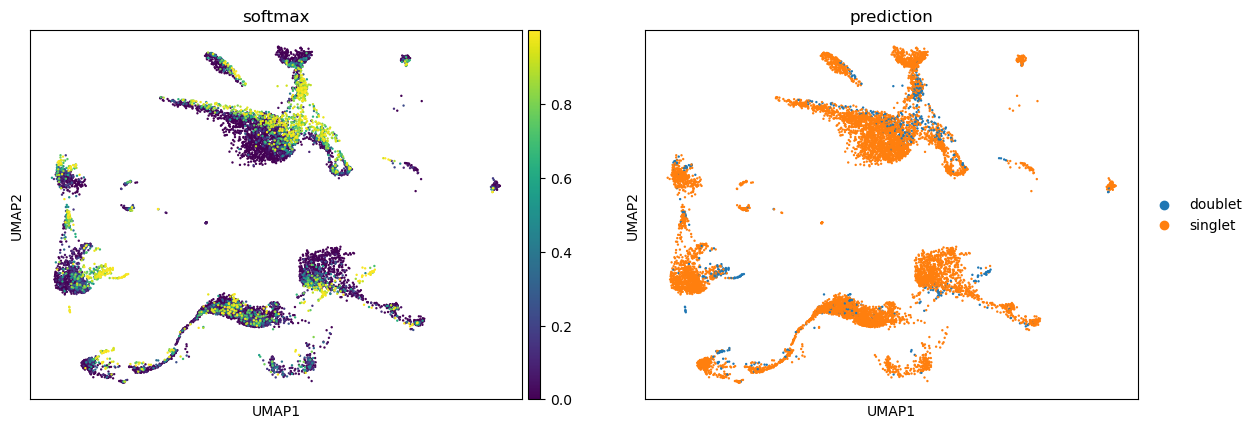

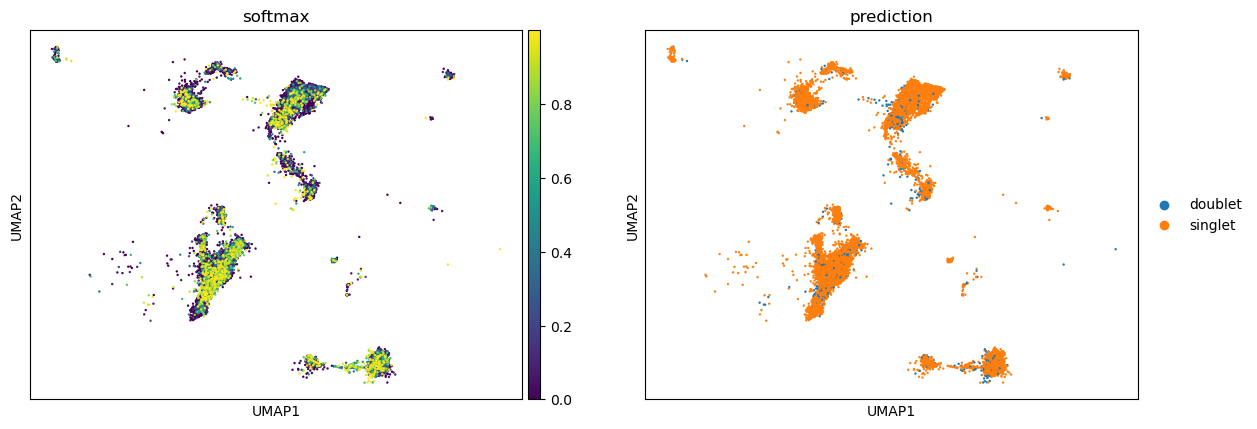

working on stage P15
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 71/600:  12%|█▏        | 71/600 [07:00<52:12,  5.92s/it, v_num=1, train_loss_step=0.0696, train_loss_epoch=0.043]  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.045. Signaling Trainer to stop.
CPU times: user 8min 33s, sys: 2min 27s, total: 11min 1s
Wall time: 7min
Epoch 31/600:   5%|▌         | 31/600 [01:29<27:26,  2.89s/it, v_num=1, train_loss_step=0.00664, train_loss_epoch=0.0404]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.035. Signaling Trainer to stop.
CPU times: user 2min 13s, sys: 1min 3s, total: 3min 17s
Wall time: 1min 29s
prediction
singlet    9587
doublet     916
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo             672     6673
epi               50      689
mes              181     2146
other             13       79
prediction      doublet  singlet
celltype                        
AT1                   9      239
AT2                  24      408
Ciliated              1        1
Club                  0       26
epi progenitor       16       11
unknown3  

/tmp/ipykernel_750450/553240500.py:29: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dat.obs['softmax'] = df.softmax


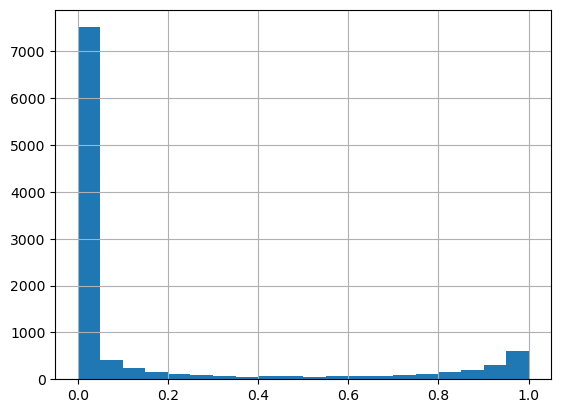

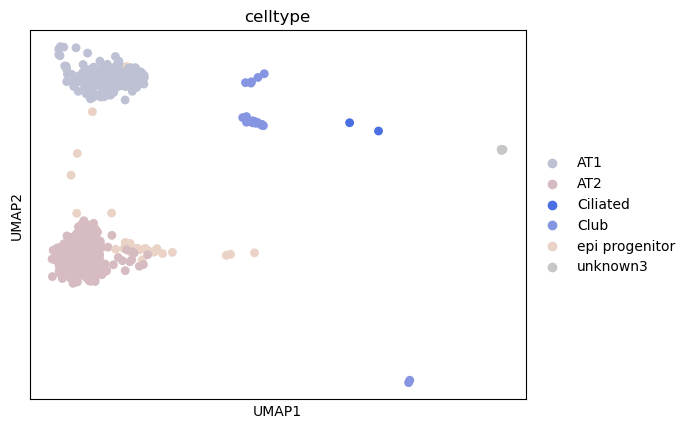

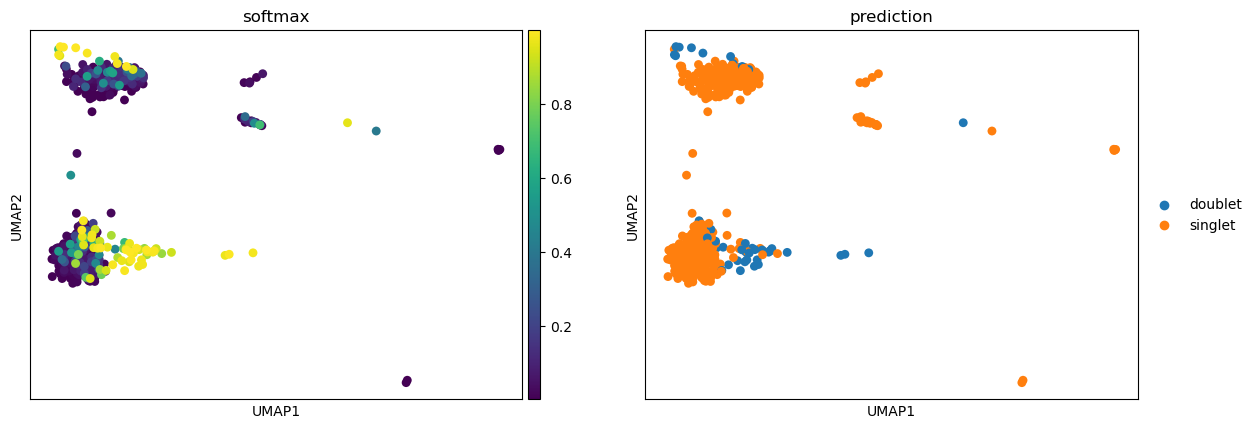

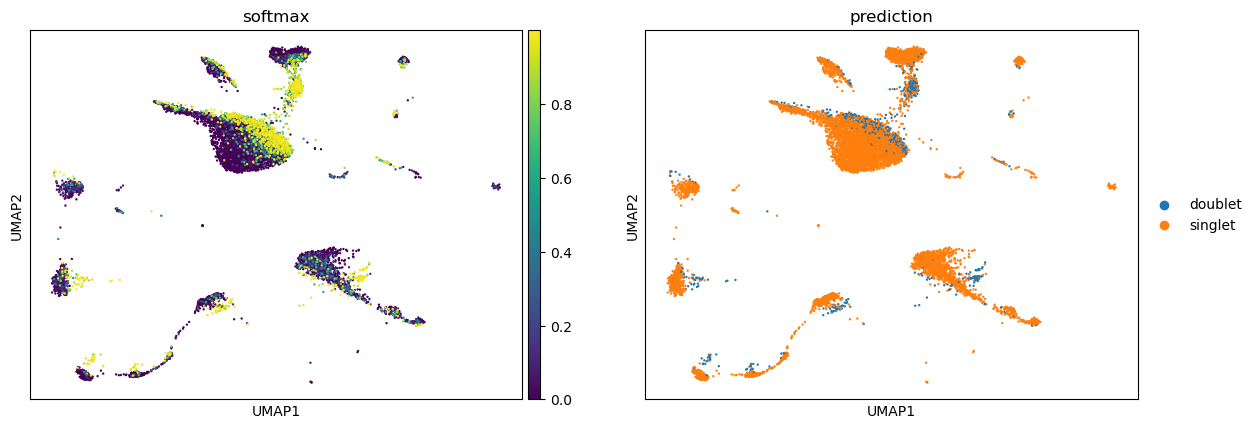

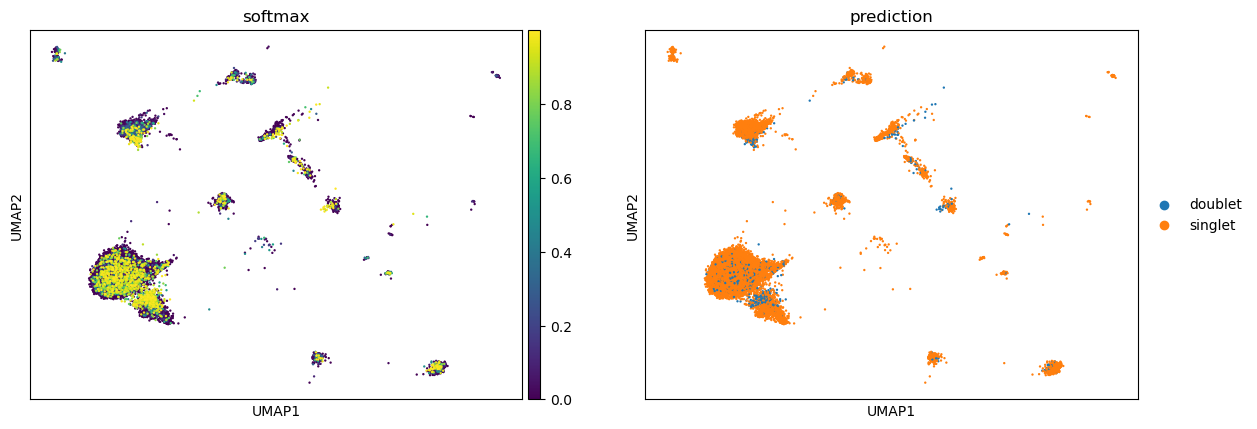

working on stage P42
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 97/600:  16%|█▌        | 97/600 [11:19<58:42,  7.00s/it, v_num=1, train_loss_step=0.018, train_loss_epoch=0.0541]    
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.057. Signaling Trainer to stop.
CPU times: user 13min 24s, sys: 3min 23s, total: 16min 47s
Wall time: 11min 19s


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 31/600:   5%|▌         | 31/600 [01:43<31:39,  3.34s/it, v_num=1, train_loss_step=0.14, train_loss_epoch=0.051]   
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.050. Signaling Trainer to stop.
CPU times: user 2min 26s, sys: 1min 4s, total: 3min 30s
Wall time: 1min 44s
prediction
singlet    10738
doublet     1471
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo             942     6704
epi              103      936
mes              416     2988
other             10      110
prediction      doublet  singlet
celltype                        
AT1                  25      330
AT2                  11      506
Ciliated              1        3
Club                  6       46
epi progenitor       60       45
unknown3              0        6


/tmp/ipykernel_750450/553240500.py:29: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dat.obs['softmax'] = df.softmax


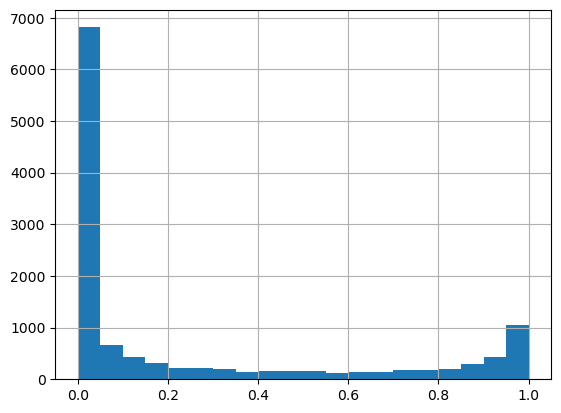

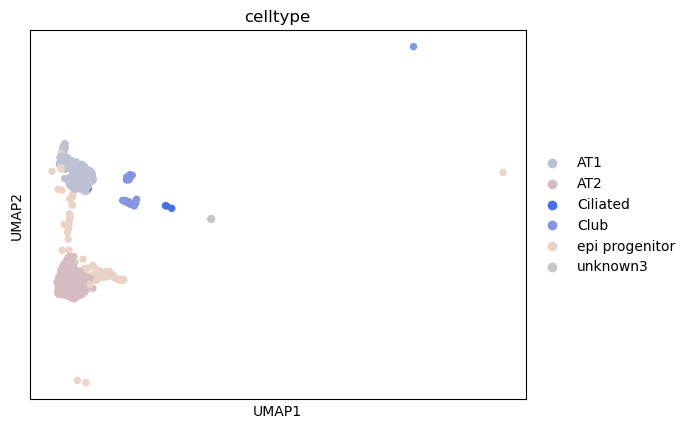

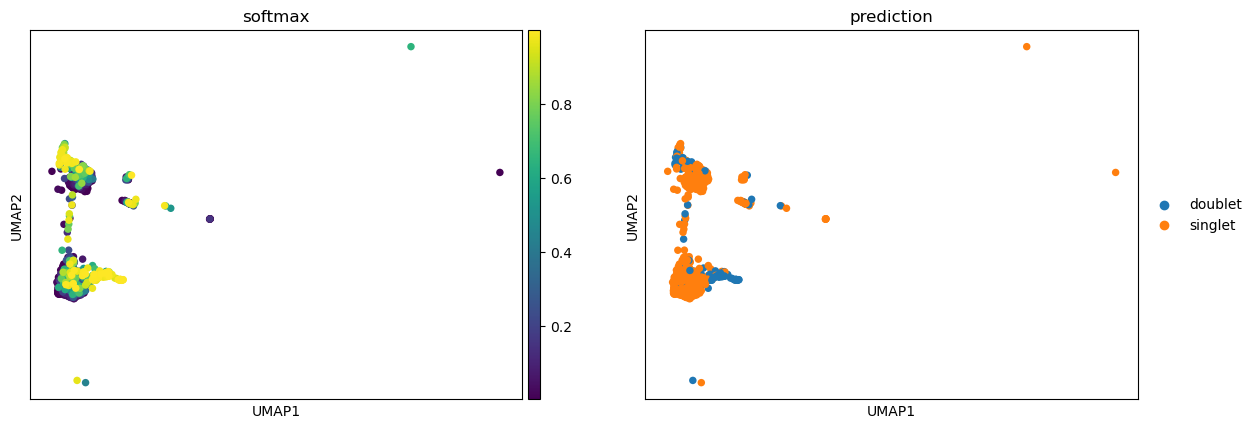

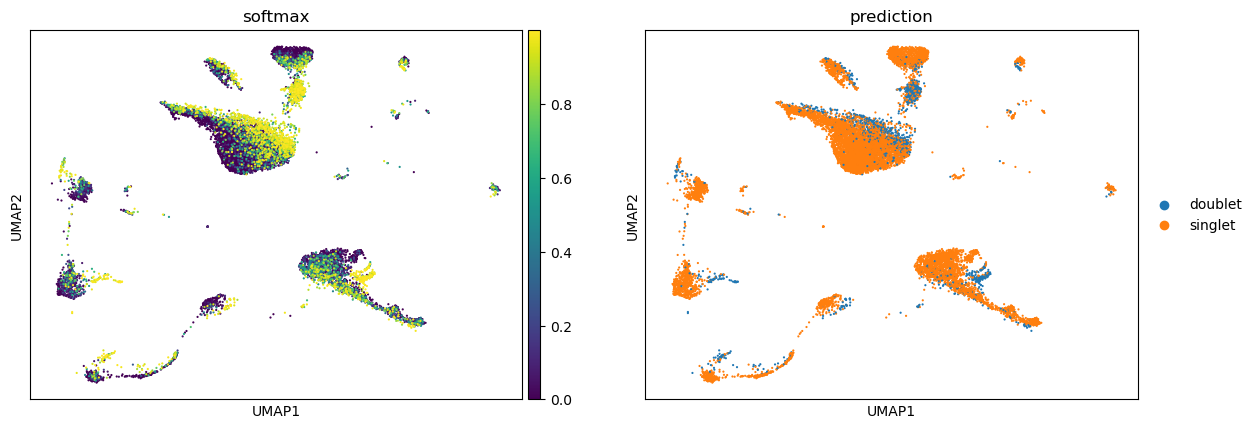

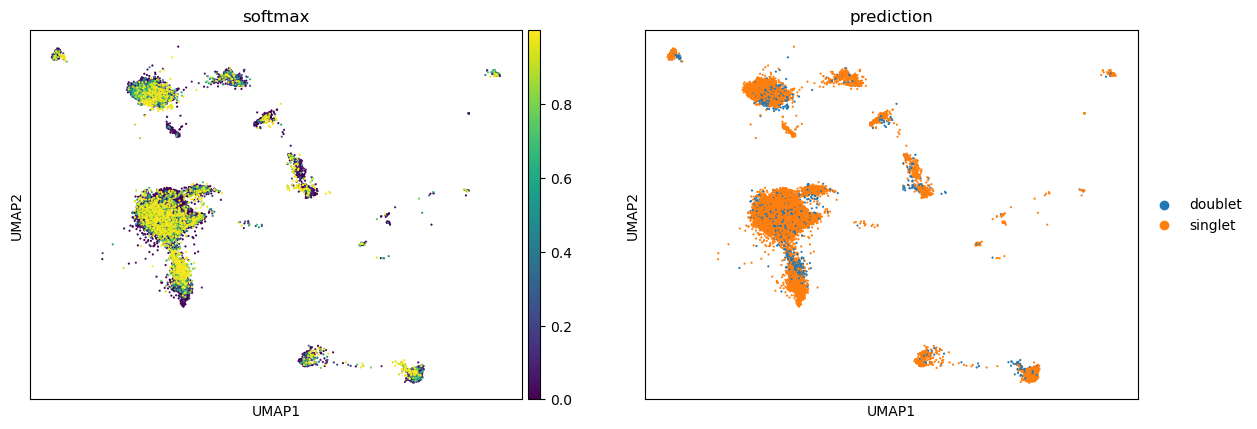

In [33]:
for stage in stages:
    print(f'working on stage {stage}')

    subdata = adata[adata.obs.development_stage==stage, adata.var.joint_highly_variable].copy()
    
    solo_batch = scvi.external.SOLO.from_scvi_model(
        vae, subdata.copy(), doublet_ratio=20, n_layers=2)

    %time solo_batch.train(accelerator='gpu', train_size=0.8, validation_size=0.1, batch_size=128, max_epochs=600)
    %time solo_batch.train(accelerator='gpu', train_size=0.8, validation_size=0.1, batch_size=256, max_epochs=600)

    df = solo_batch.predict()
    df['softmax'] = np.exp(df['doublet'])/np.sum(np.exp(df[['singlet', 'doublet']]), axis=1)
    df['prediction'] = np.where(df['softmax'] > 0.9, 'doublet', 'singlet')

    print(df.prediction.value_counts())
    
    df.softmax.hist(bins=np.linspace(0,1,21))
    
    subdata.obs['prediction'] = df.prediction
    subdata.obs['softmax'] = df.softmax
    
    print(pd.crosstab(subdata.obs.compartment, subdata.obs.prediction))
    
    comp = 'epi'
    plot_dat = subdata[(subdata.obs.compartment==comp)]
    dat = vae_adata[adata.obs.development_stage==stage]
    
    dat.obs['softmax'] = df.softmax
    dat.obs['prediction'] = df.prediction
    
    print(pd.crosstab(plot_dat.obs.celltype, plot_dat.obs.prediction))

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        sc.pl.umap(plot_dat, color=['celltype'])
        sc.pl.umap(plot_dat, color=['softmax', 'prediction'])
        sc.pl.umap(subdata, color=['softmax', 'prediction'])
        
        sc.pl.umap(dat, color=['softmax', 'prediction'])
    
    adata.obs.loc[subdata.obs_names, 'doublet_softmax'] = subdata.obs.softmax

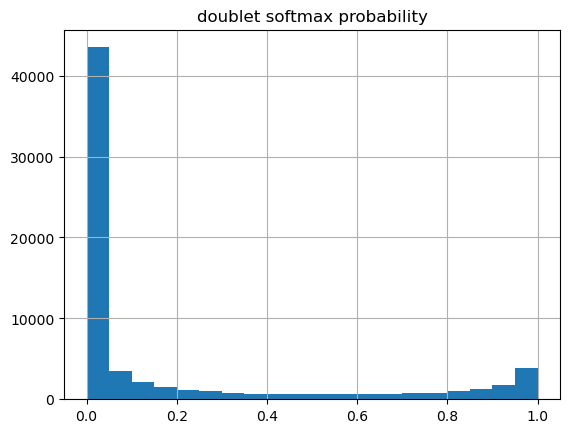

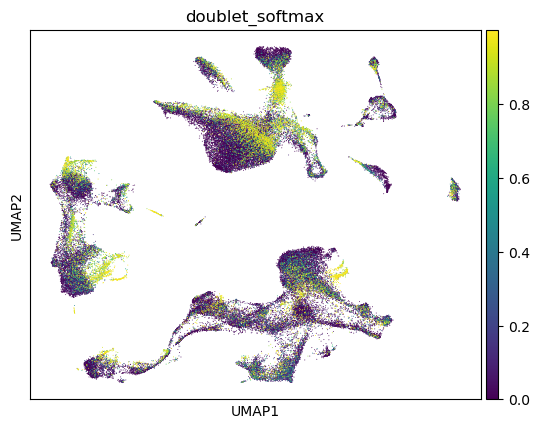

In [34]:
adata.obs['doublet_softmax'].hist(bins=np.linspace(0,1,21))
plt.title('doublet softmax probability')
sc.pl.umap(adata, color='doublet_softmax')

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


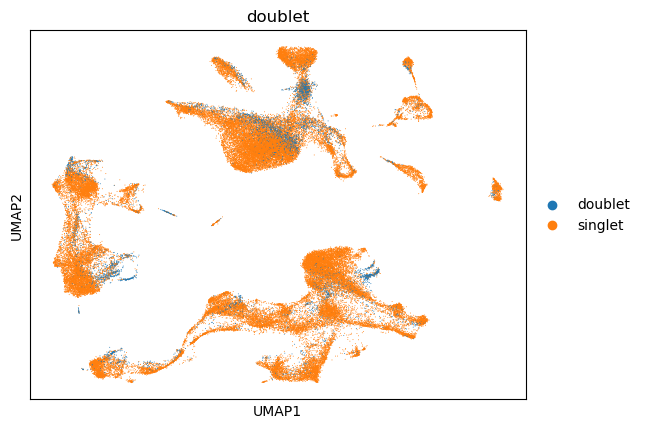

In [35]:
adata.obs['doublet'] = np.where(adata.obs['doublet_softmax'] > 0.9, 'doublet', 'singlet')
sc.pl.umap(adata, color='doublet')

In [42]:
adata.obs['doublet_softmax_r2'] = np.nan

working on stage E12
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 76/600:  13%|█▎        | 76/600 [02:57<20:21,  2.33s/it, v_num=1, train_loss_step=0.0338, train_loss_epoch=0.0374]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.043. Signaling Trainer to stop.
CPU times: user 4min 43s, sys: 2min 36s, total: 7min 20s
Wall time: 2min 57s
Epoch 31/600:   5%|▌         | 31/600 [00:39<12:02,  1.27s/it, v_num=1, train_loss_step=0.0141, train_loss_epoch=0.0319]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.029. Signaling Trainer to stop.
CPU times: user 1min 16s, sys: 54.4 s, total: 2min 11s
Wall time: 39.5 s
prediction
singlet    8314
doublet     122
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo               2      123
epi               10      631
mes              105     7221
other              5      339
prediction      doublet  singlet
celltype                        
AT1                   1      116
AT2                   0       52
Club                  2      106
epi progenitor        6      263
unknown3              1       94


<timed exec>:30: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


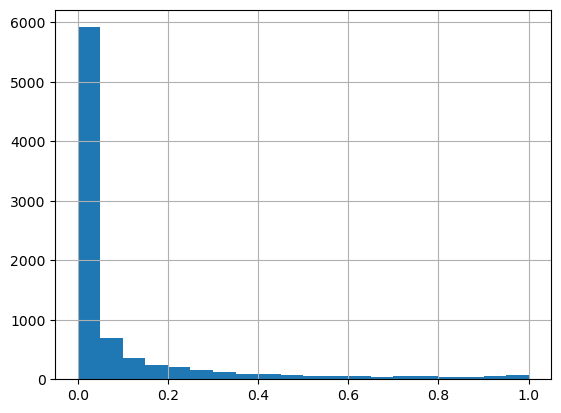

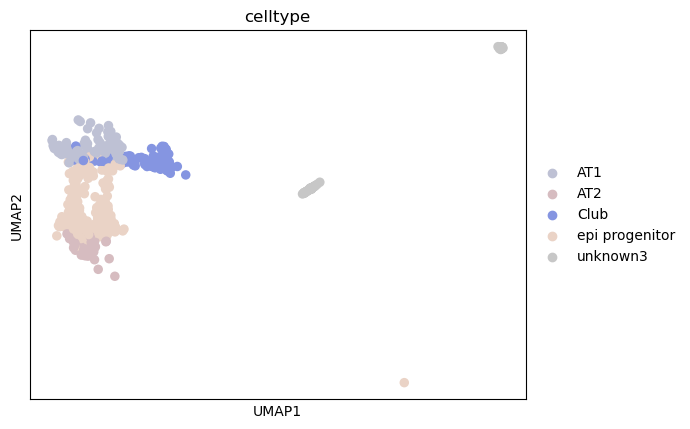

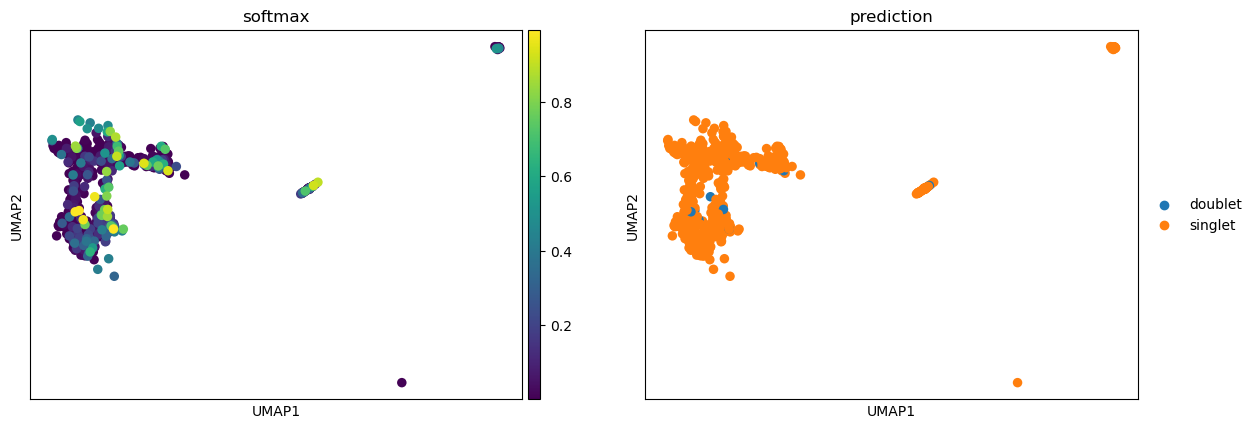

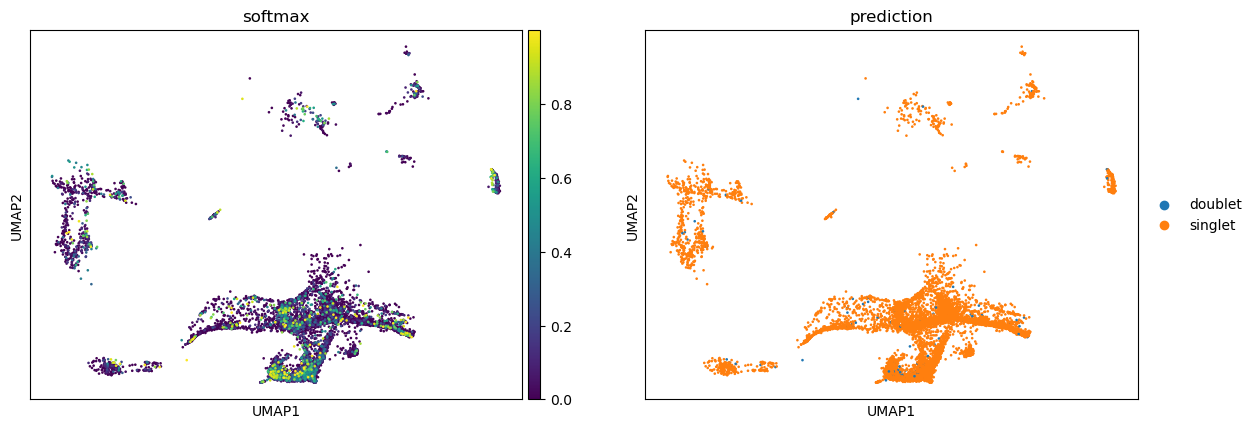

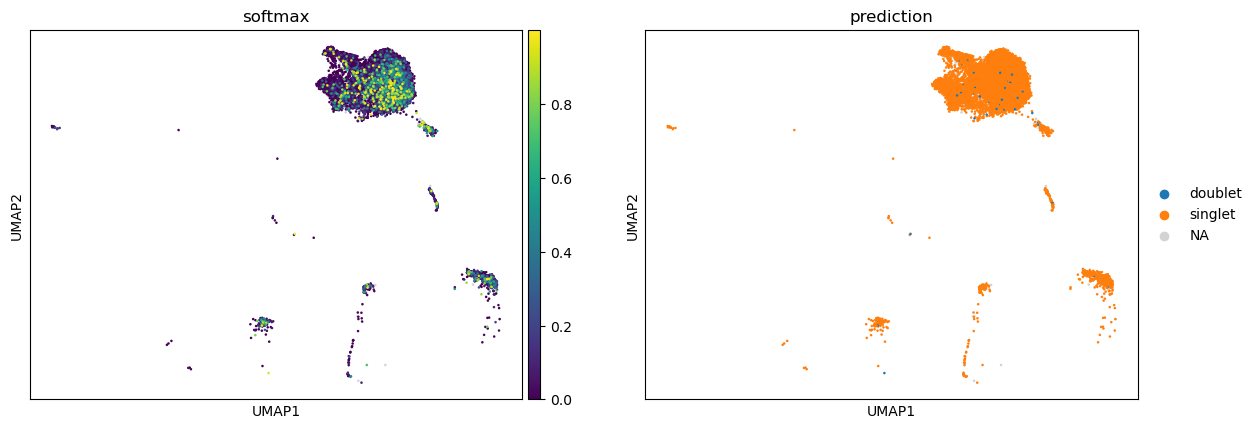

working on stage E15
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 88/600:  15%|█▍        | 88/600 [03:10<18:28,  2.17s/it, v_num=1, train_loss_step=0.0477, train_loss_epoch=0.0446] 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.059. Signaling Trainer to stop.
CPU times: user 5min 13s, sys: 3min, total: 8min 13s
Wall time: 3min 10s
Epoch 31/600:   5%|▌         | 31/600 [00:36<11:07,  1.17s/it, v_num=1, train_loss_step=0.0958, train_loss_epoch=0.0416] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.034. Signaling Trainer to stop.
CPU times: user 1min 12s, sys: 52.5 s, total: 2min 5s
Wall time: 36.5 s
prediction
singlet    7639
doublet     142
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              29      984
epi               89     3338
mes               19     2374
other              5      943


<timed exec>:30: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


prediction      doublet  singlet
celltype                        
AT1                  25      621
AT2                   1      241
Club                  6      387
epi progenitor       57     2085
unknown3              0        4


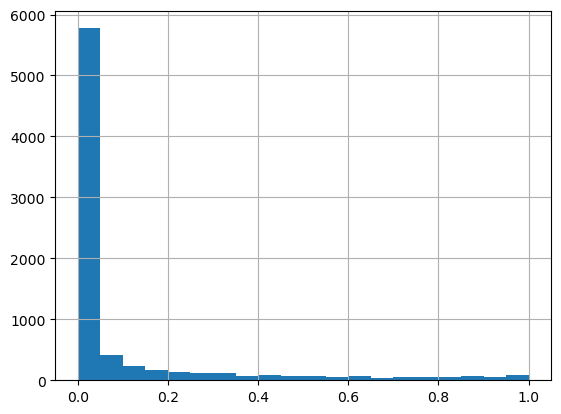

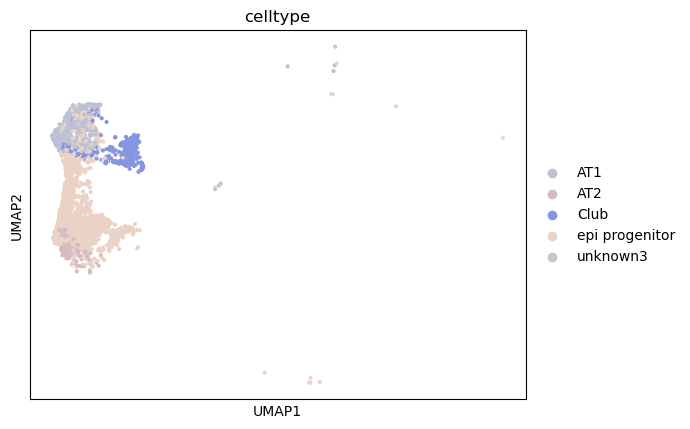

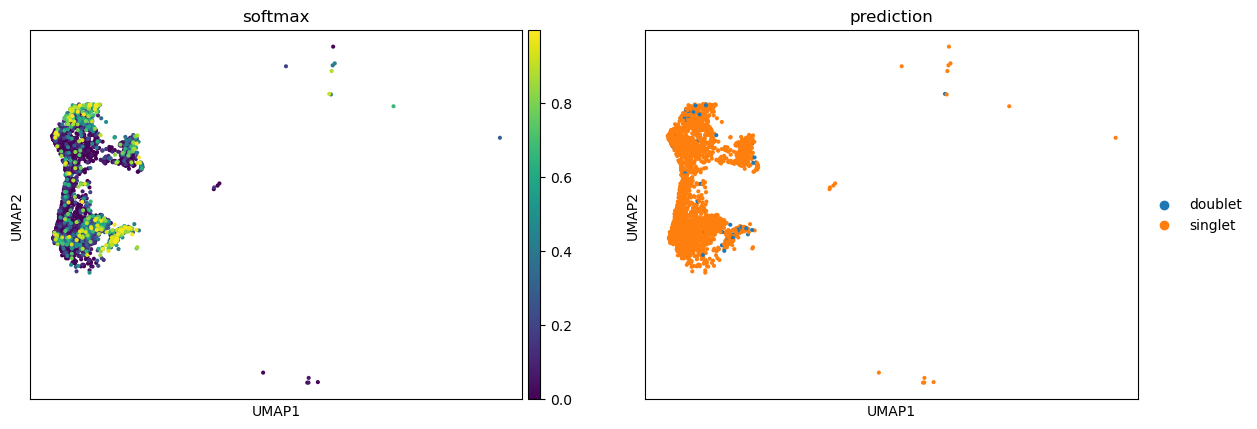

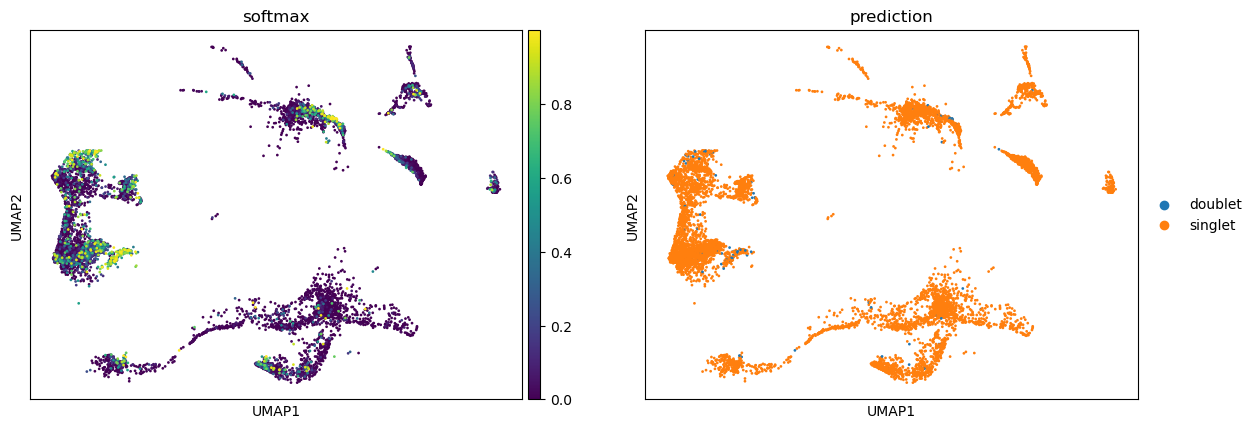

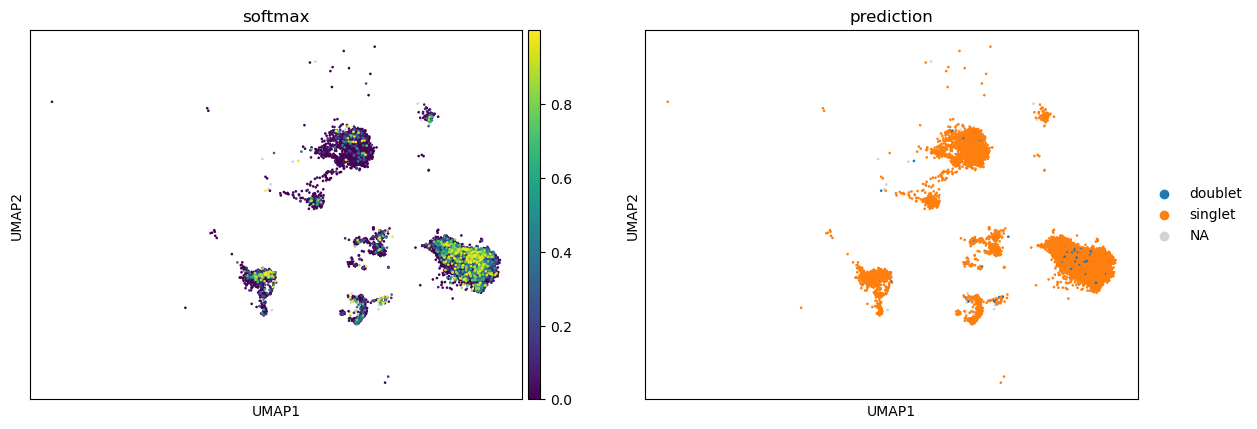

working on stage E17
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 73/600:  12%|█▏        | 73/600 [02:17<16:31,  1.88s/it, v_num=1, train_loss_step=0.15, train_loss_epoch=0.0454]  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.060. Signaling Trainer to stop.
CPU times: user 3min 56s, sys: 2min 24s, total: 6min 21s
Wall time: 2min 17s
Epoch 31/600:   5%|▌         | 31/600 [00:31<09:35,  1.01s/it, v_num=1, train_loss_step=0.0193, train_loss_epoch=0.0389]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.035. Signaling Trainer to stop.
CPU times: user 1min 6s, sys: 51 s, total: 1min 57s
Wall time: 31.5 s
prediction
singlet    6609
doublet     162
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              29     1549
epi               87     2290
mes               31     1889
other             15      881
prediction      doublet  singlet
celltype                        
AT1                  15      719
AT2                   4      732
Ciliated              1        2
Club                  7      145
epi progenitor       60      689
unknown3     

<timed exec>:30: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


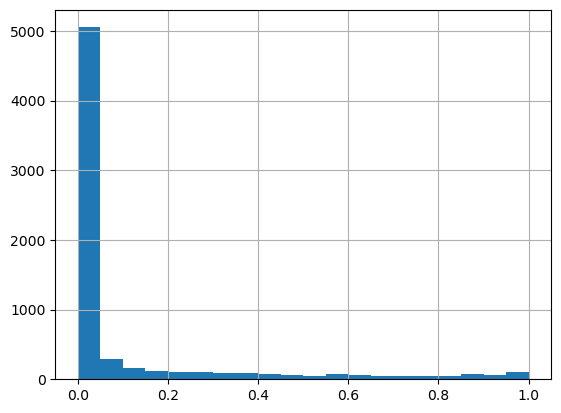

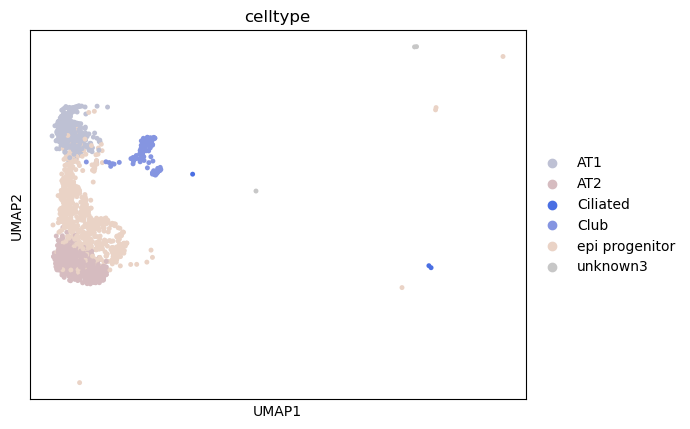

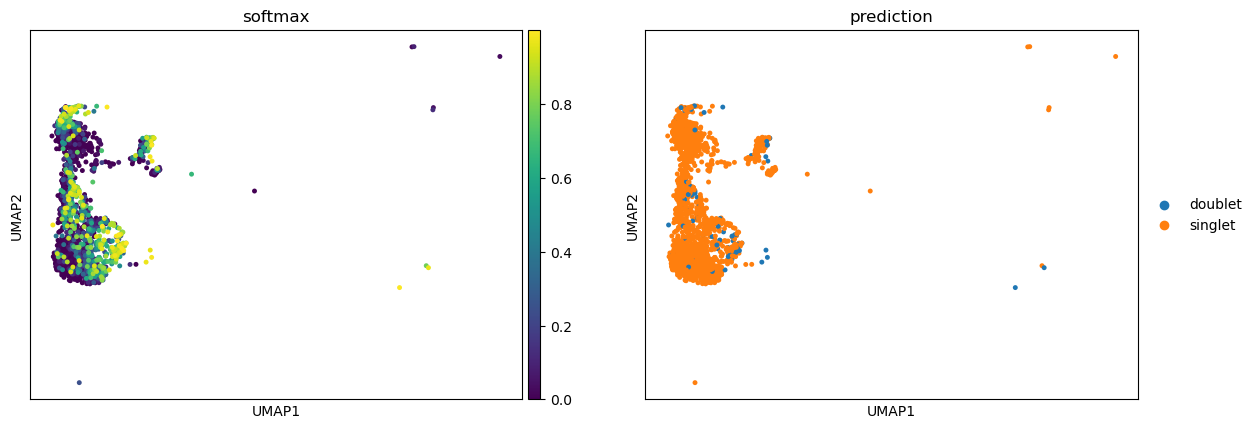

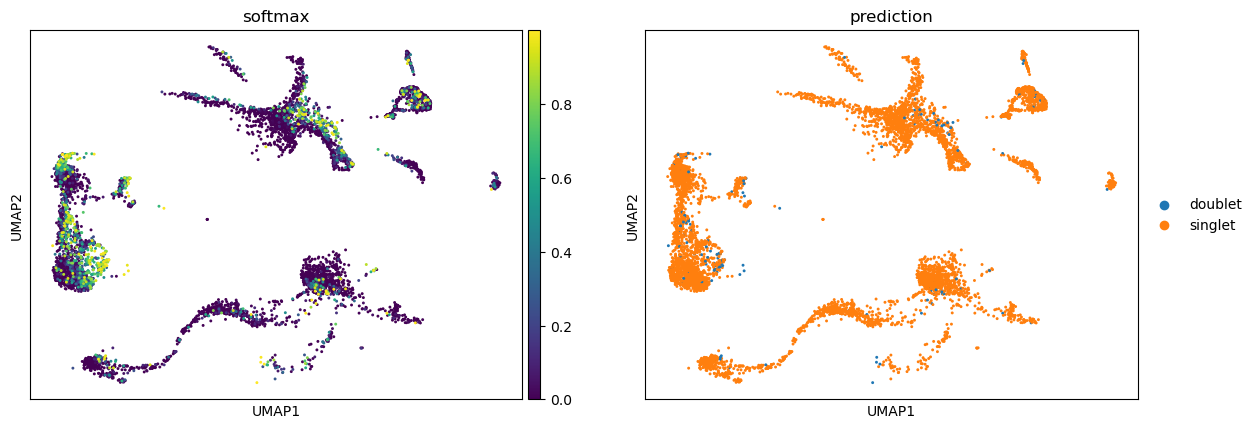

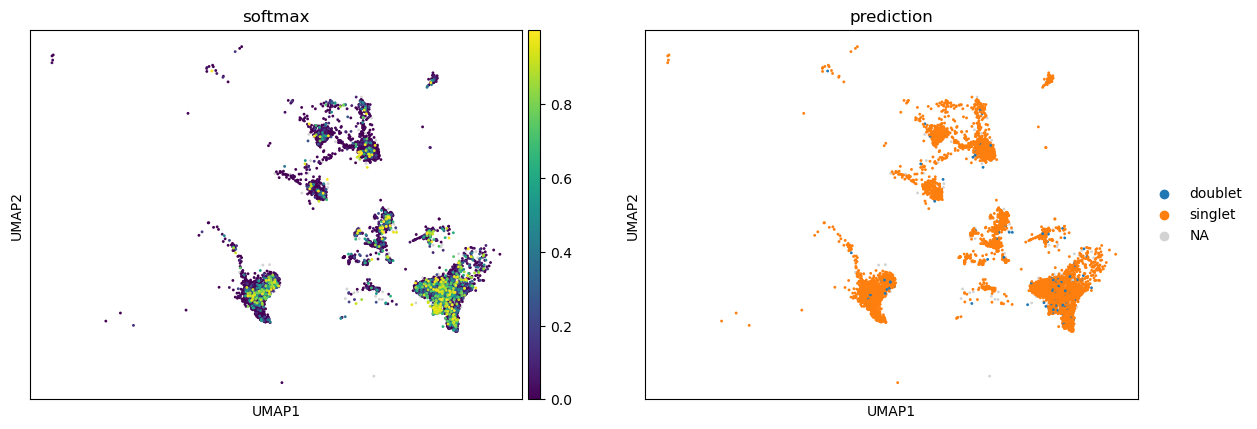

working on stage P3
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 97/600:  16%|█▌        | 97/600 [04:14<21:58,  2.62s/it, v_num=1, train_loss_step=0.0393, train_loss_epoch=0.0371] 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.044. Signaling Trainer to stop.
CPU times: user 6min 29s, sys: 3min 19s, total: 9min 49s
Wall time: 4min 14s
Epoch 31/600:   5%|▌         | 31/600 [00:44<13:28,  1.42s/it, v_num=1, train_loss_step=0.047, train_loss_epoch=0.0322]  
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.021. Signaling Trainer to stop.
CPU times: user 1min 22s, sys: 56 s, total: 2min 18s
Wall time: 44.2 s
prediction
singlet    9509
doublet     127
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              33     2764
epi               45     1882
mes               48     4735
other              1      128
prediction      doublet  singlet
celltype                        
AT1                  12      794
AT2                   5      790
Ciliated              2       16
Club                  1       88
epi progenitor       25      183
unknown3   

<timed exec>:30: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


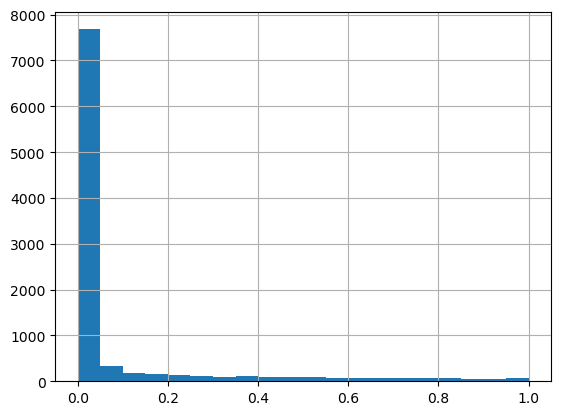

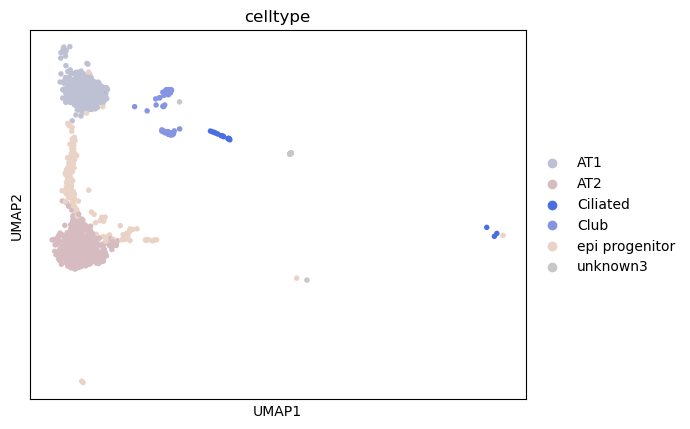

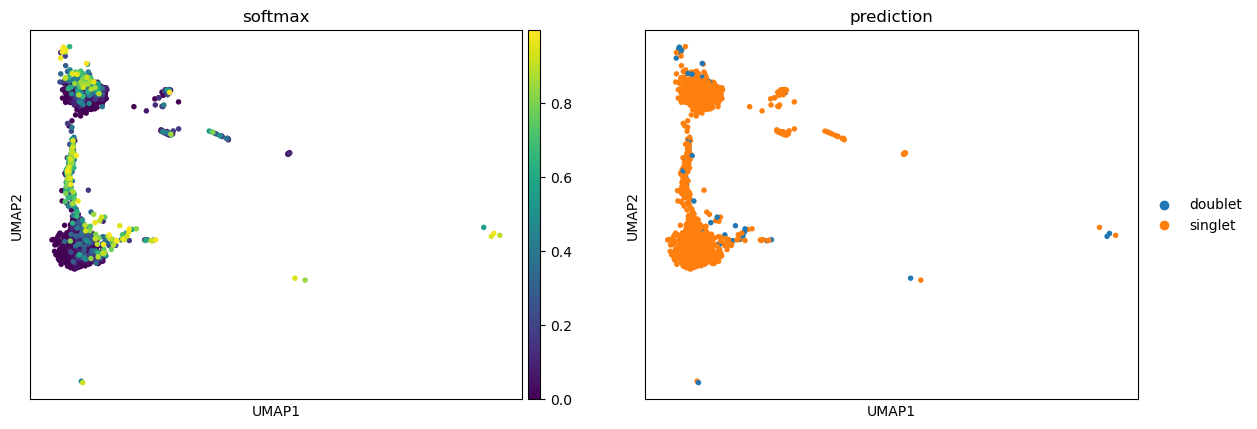

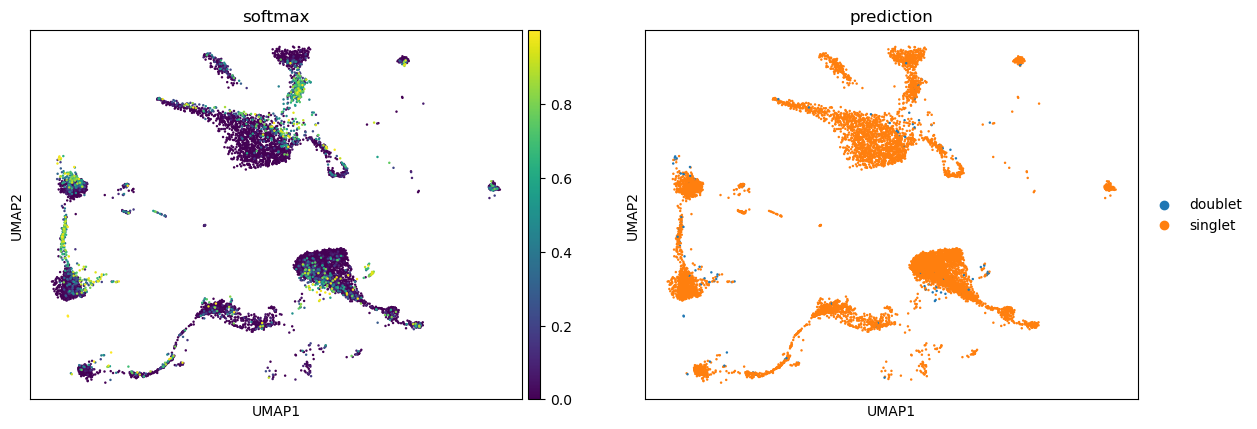

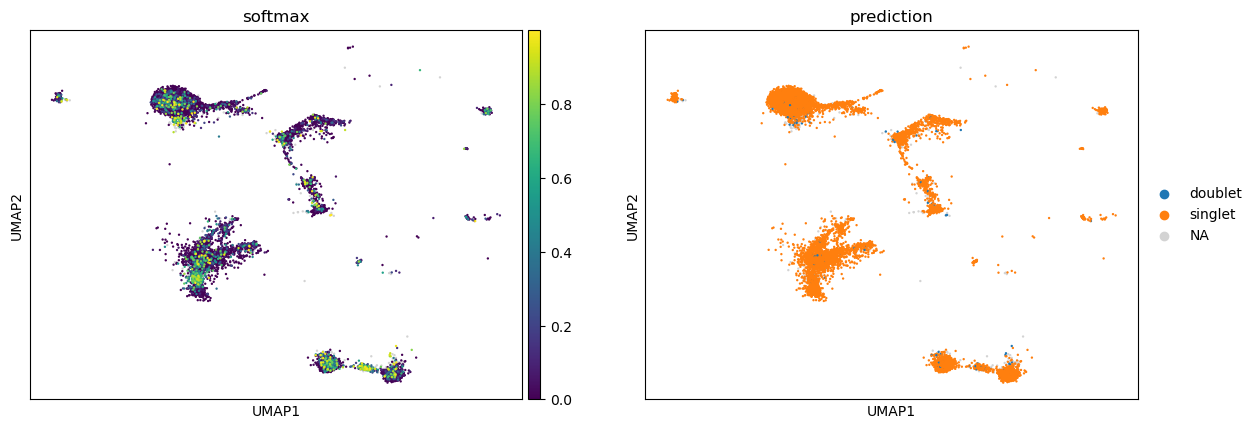

working on stage P7
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 63/600:  10%|█         | 63/600 [02:44<23:26,  2.62s/it, v_num=1, train_loss_step=0.134, train_loss_epoch=0.055]  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.063. Signaling Trainer to stop.
CPU times: user 4min 13s, sys: 2min 10s, total: 6min 23s
Wall time: 2min 45s
Epoch 31/600:   5%|▌         | 31/600 [00:44<13:34,  1.43s/it, v_num=1, train_loss_step=0.0157, train_loss_epoch=0.0477] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.046. Signaling Trainer to stop.
CPU times: user 1min 23s, sys: 56.6 s, total: 2min 20s
Wall time: 44.5 s
prediction
singlet    9339
doublet     237
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo             126     3618
epi               37     1449
mes               72     4166
other              2      106


<timed exec>:30: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


prediction      doublet  singlet
celltype                        
AT1                  10      308
AT2                   1      804
Ciliated              0        3
Club                  3       68
epi progenitor       23      254
unknown3              0       12


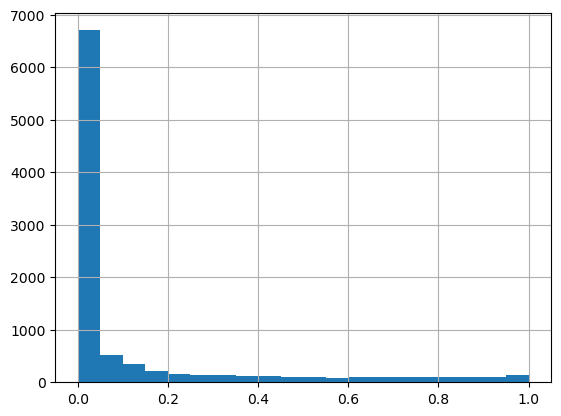

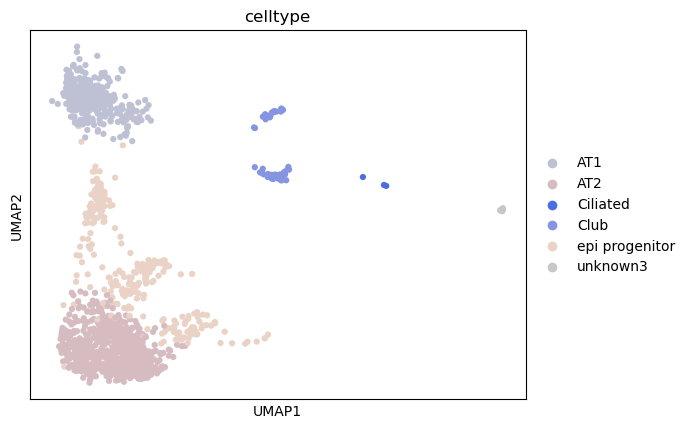

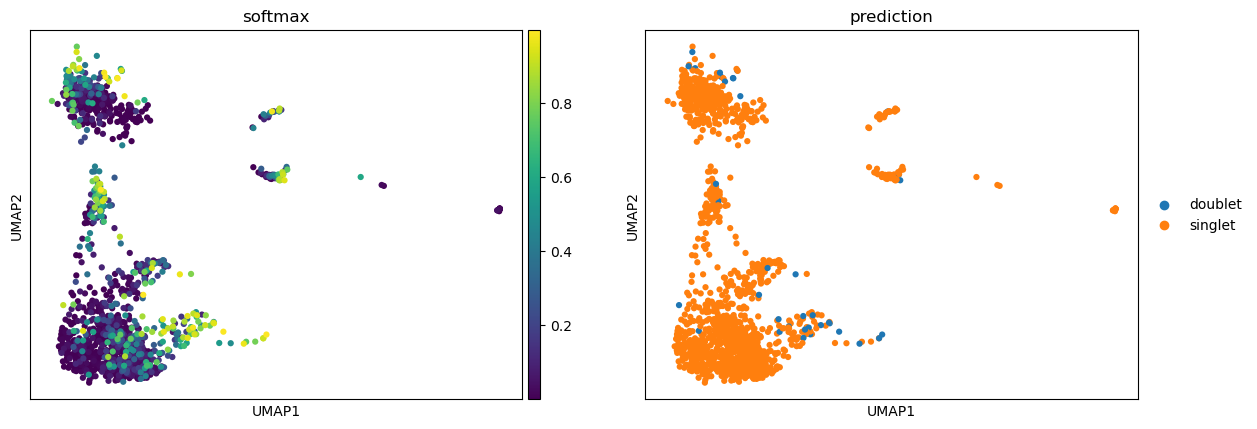

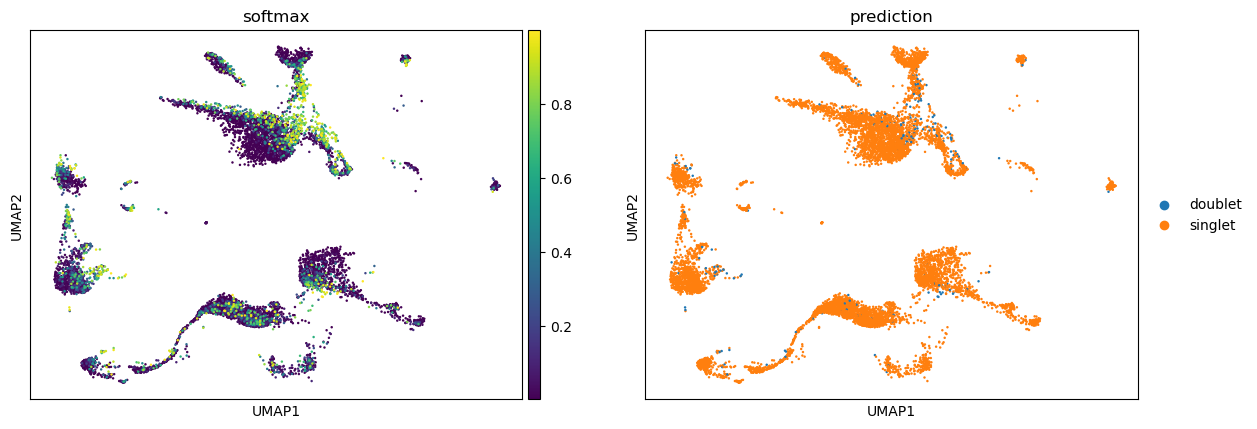

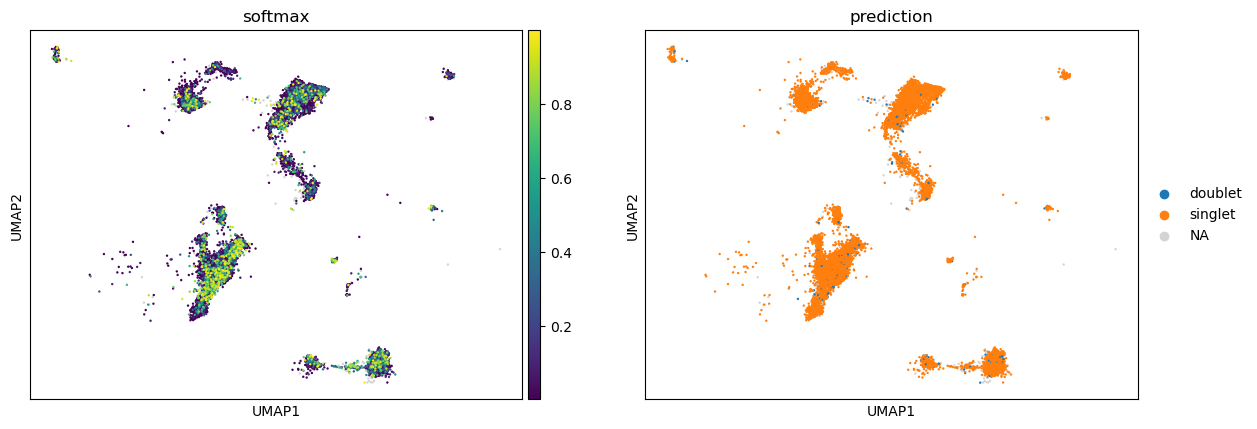

working on stage P15
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 72/600:  12%|█▏        | 72/600 [03:13<23:36,  2.68s/it, v_num=1, train_loss_step=0.0178, train_loss_epoch=0.039]  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.056. Signaling Trainer to stop.
CPU times: user 4min 53s, sys: 2min 29s, total: 7min 23s
Wall time: 3min 13s
Epoch 31/600:   5%|▌         | 31/600 [00:44<13:42,  1.45s/it, v_num=1, train_loss_step=0.0164, train_loss_epoch=0.0353]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.029. Signaling Trainer to stop.
CPU times: user 1min 23s, sys: 56.8 s, total: 2min 20s
Wall time: 45 s
prediction
singlet    9550
doublet     189
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo             151     6660
epi               11      684
mes               22     2135
other              5       71
prediction      doublet  singlet
celltype                        
AT1                   1      240
AT2                   6      406
Ciliated              0        1
Club                  0       26
epi progenitor        4        7
unknown3    

<timed exec>:30: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


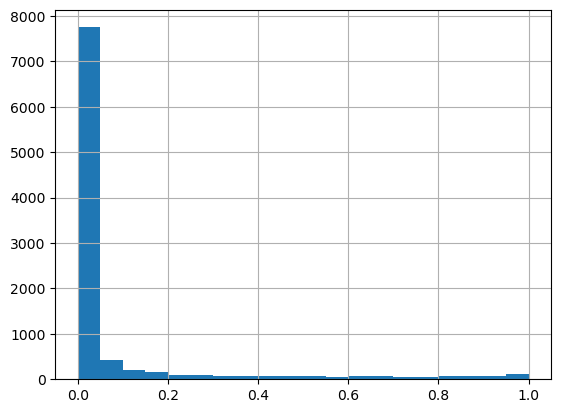

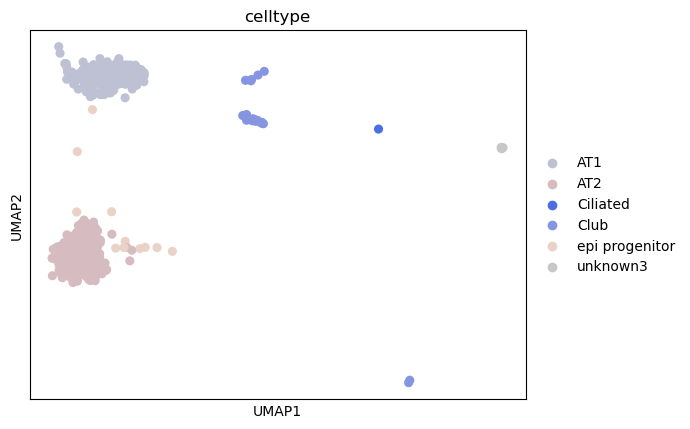

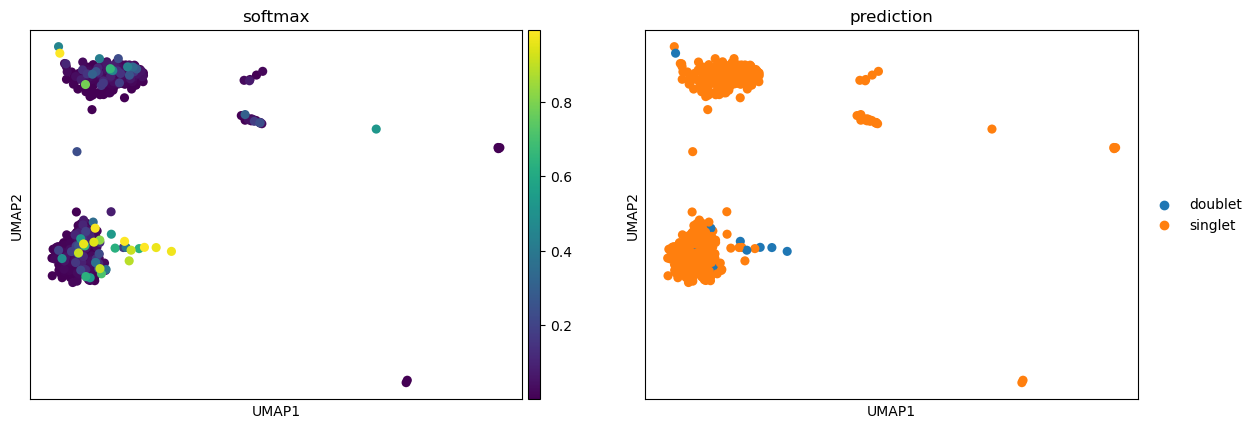

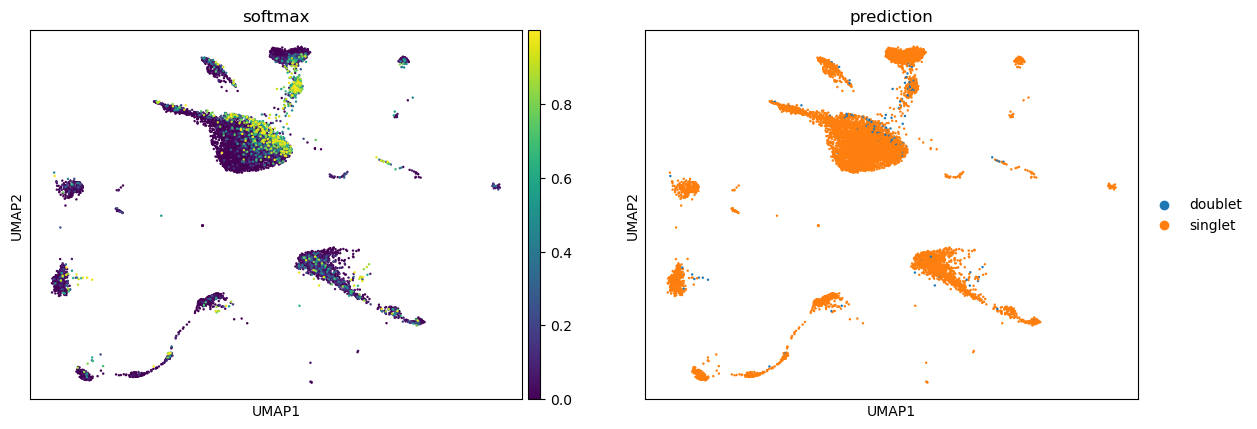

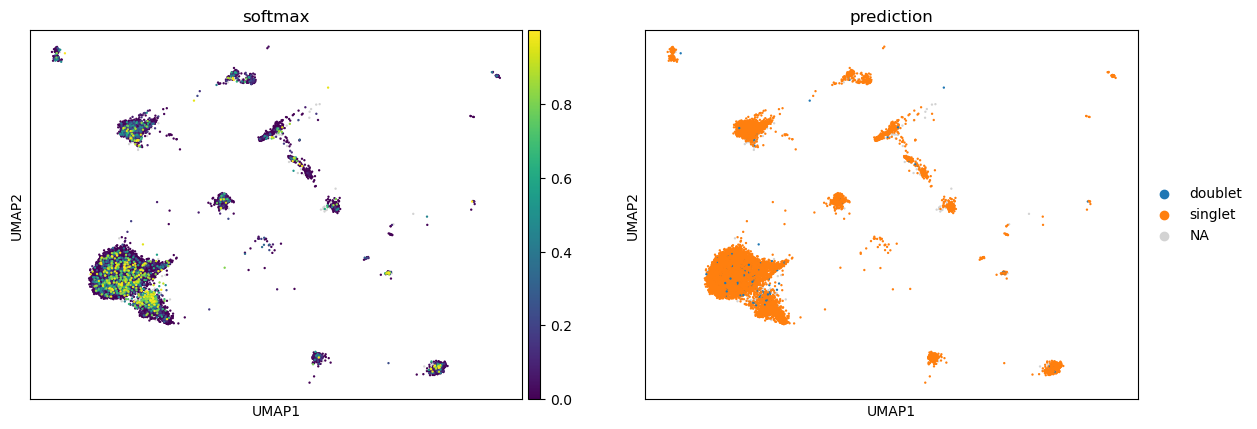

working on stage P42
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 71/600:  12%|█▏        | 71/600 [03:34<26:36,  3.02s/it, v_num=1, train_loss_step=0.044, train_loss_epoch=0.053]   

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.061. Signaling Trainer to stop.
CPU times: user 5min 13s, sys: 2min 26s, total: 7min 39s
Wall time: 3min 34s
Epoch 31/600:   5%|▌         | 31/600 [00:50<15:27,  1.63s/it, v_num=1, train_loss_step=0.0336, train_loss_epoch=0.0479]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.045. Signaling Trainer to stop.
CPU times: user 1min 31s, sys: 59.6 s, total: 2min 31s
Wall time: 50.7 s
prediction
singlet    10716
doublet      269
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo             171     6758
epi               19      905
mes               70     2952
other              9      101
prediction      doublet  singlet
celltype                        
AT1                   3      320
AT2                   4      497
Ciliated              0        3
Club                  1       44
epi progenitor       11       35
unknown3

<timed exec>:30: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


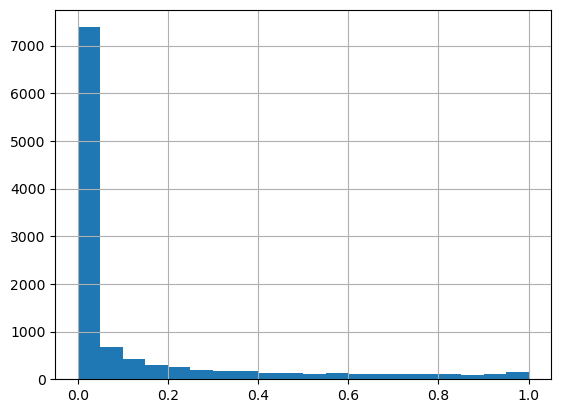

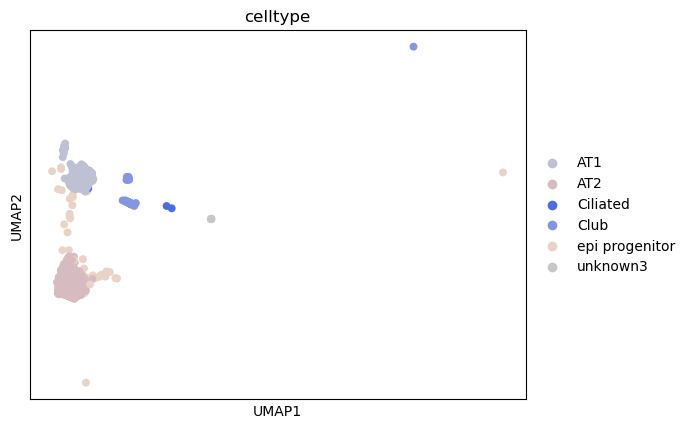

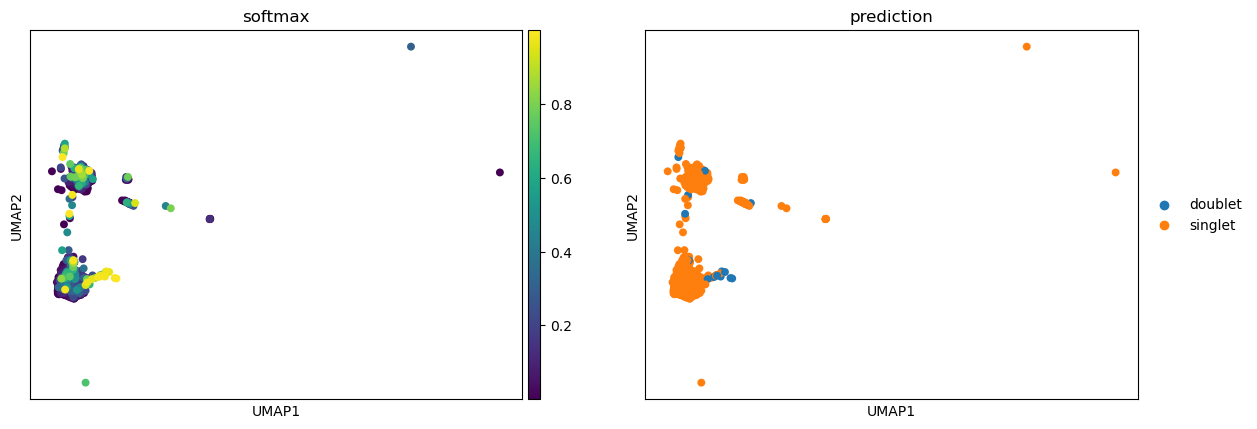

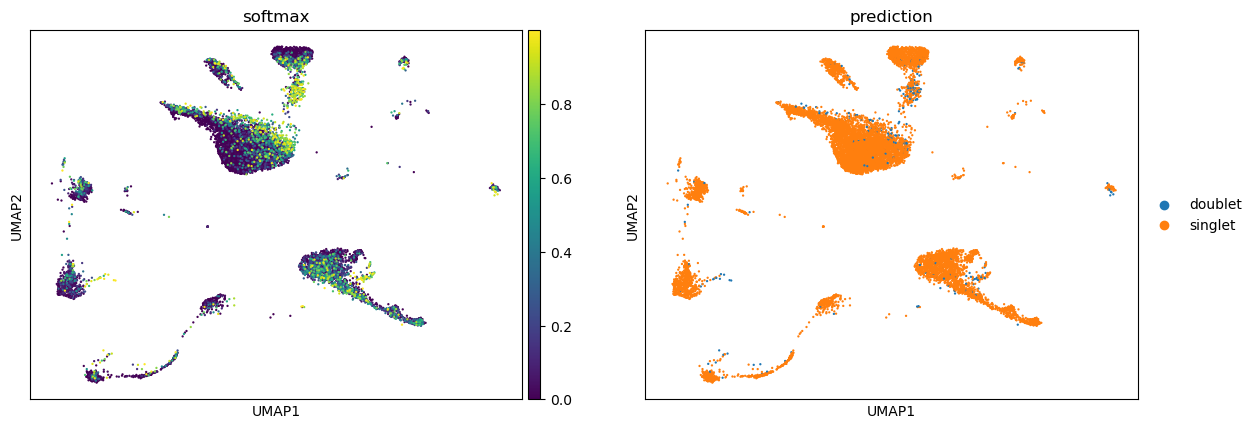

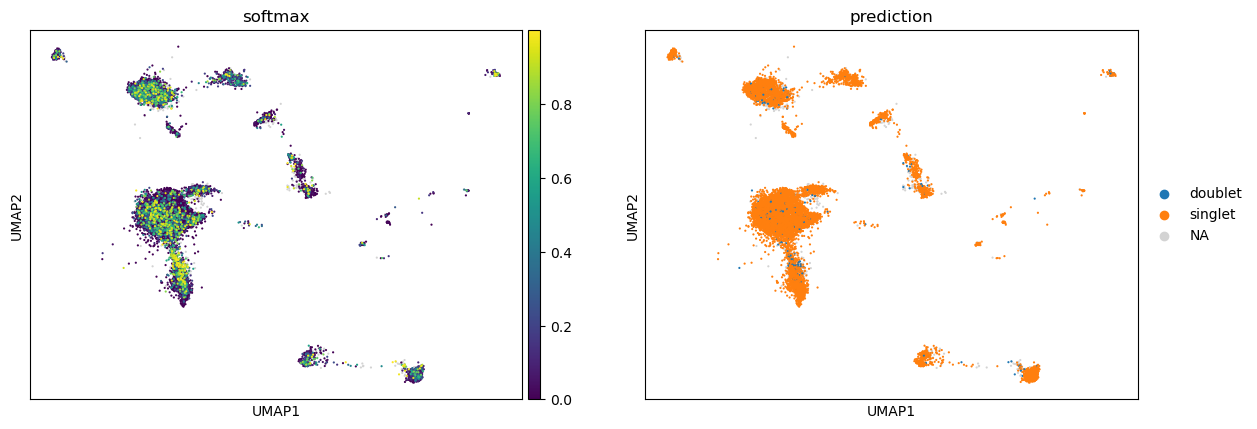

CPU times: user 45min 1s, sys: 25min 4s, total: 1h 10min 6s
Wall time: 28min 2s


In [43]:
%%time
r2_data = adata[adata.obs.doublet == 'singlet']

for stage in stages:
    print(f'working on stage {stage}')
    
    subdata = r2_data[r2_data.obs.development_stage==stage, r2_data.var.joint_highly_variable].copy()
    solo_batch = scvi.external.SOLO.from_scvi_model(
        vae, subdata.copy(), doublet_ratio=10, n_layers=2)

    %time solo_batch.train(accelerator='gpu', train_size=0.8, validation_size=0.1, batch_size=128, max_epochs=600)
    %time solo_batch.train(accelerator='gpu', train_size=0.8, validation_size=0.1, batch_size=256, max_epochs=600)

    df = solo_batch.predict()
    df['softmax'] = np.exp(df['doublet'])/np.sum(np.exp(df[['singlet', 'doublet']]), axis=1)
    df['prediction'] = np.where(df['softmax'] > 0.9, 'doublet', 'singlet')

    print(df.prediction.value_counts())
    
    df.softmax.hist(bins=np.linspace(0,1,21))
    
    subdata.obs['prediction'] = df.prediction
    subdata.obs['softmax'] = df.softmax
    
    print(pd.crosstab(subdata.obs.compartment, subdata.obs.prediction))
    
    comp = 'epi'
    plot_dat = subdata[(subdata.obs.compartment==comp)]
    dat = vae_adata[adata.obs.development_stage==stage]
    
    dat.obs['softmax'] = df.softmax
    dat.obs['prediction'] = df.prediction
    
    print(pd.crosstab(plot_dat.obs.celltype, plot_dat.obs.prediction))

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        sc.pl.umap(plot_dat, color=['celltype'])
        sc.pl.umap(plot_dat, color=['softmax', 'prediction'])
        sc.pl.umap(subdata, color=['softmax', 'prediction'])
        
        sc.pl.umap(dat, color=['softmax', 'prediction'])
    
    adata.obs.loc[subdata.obs_names, 'doublet_softmax_r2'] = subdata.obs.softmax

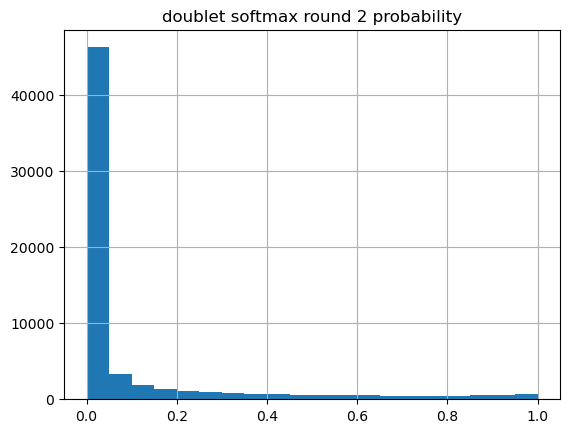

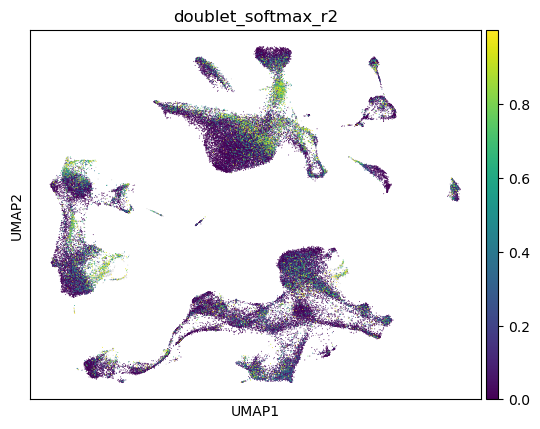

In [44]:
adata.obs['doublet_softmax_r2'].hist(bins=np.linspace(0,1,21))
plt.title('doublet softmax round 2 probability')
sc.pl.umap(adata, color='doublet_softmax_r2')

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


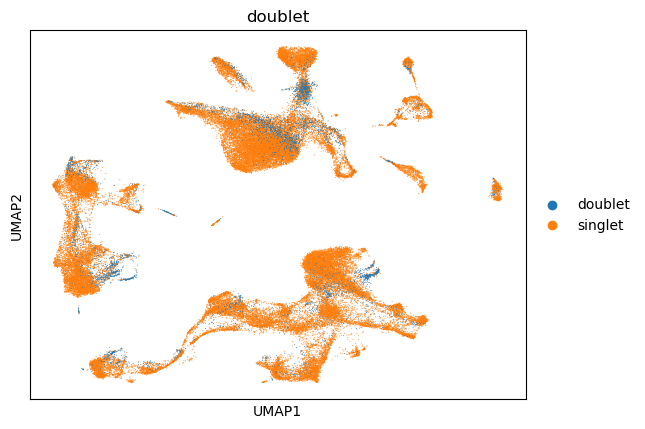

In [48]:
adata.obs['doublet'] = np.where((adata.obs['doublet_softmax'] > 0.9) | (adata.obs['doublet_softmax_r2'] > 0.9), 'doublet', 'singlet')
sc.pl.umap(adata, color='doublet')

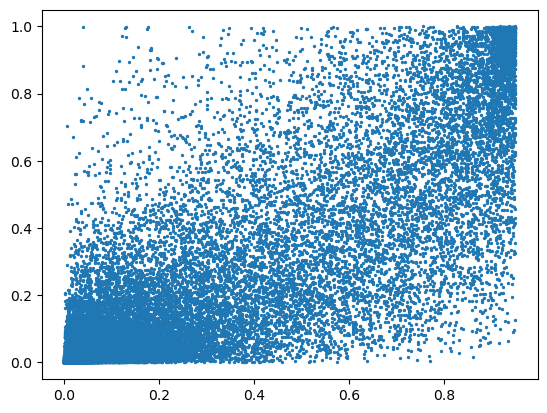

In [49]:
plt.scatter(adata.obs.doublet_softmax, adata.obs.doublet_softmax_r2, s=2)

In [50]:
no_doublets = adata[adata.obs.doublet == 'singlet']
no_doublets = no_doublets[no_doublets.obs.compartment == 'epi']
pd.crosstab(no_doublets.obs.celltype, no_doublets.obs.development_stage)

development_stage  E12   E15  E17   P3   P7  P15  P42
celltype                                             
AT1                111   618  727  782  311  239  330
AT2                 50   241  732  781  805  404  504
Ciliated             0     0    2   14    3    1    3
Club               102   382  148   85   67   26   45
epi progenitor     261  2055  707  161  271    9   42
unknown3            92     4    3   11   12    4    6

### Silhouette

In [145]:
import warnings

from sklearn.metrics import silhouette_samples

In [65]:
dat = adata[(adata.obs.doublet=='singlet')].copy()
dat = dat[~dat.obs.celltype.str.startswith('unknown')]
dat.shape

(60342, 16964)

In [66]:
dat.obs['silhouette_scvi_stage'] = np.nan

/tmp/ipykernel_750450/3412605439.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dat.obs['silhouette_scvi_stage'] = np.nan


working on stage E12


<timed exec>:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.08359573


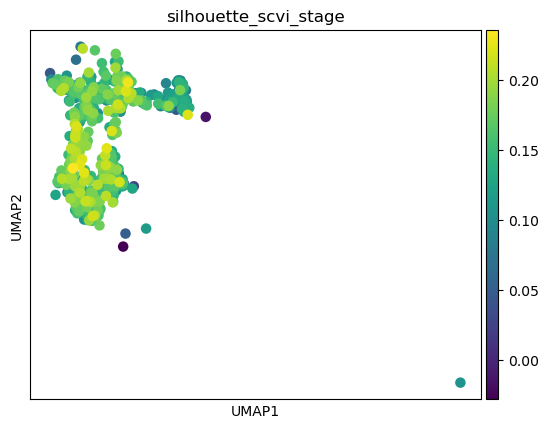

silhouette_scvi_stage  False  True 
compartment                        
endo                     102     16
epi                      519      5
mes                     7063    162
other                    248     90
working on stage E15


<timed exec>:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.09879749


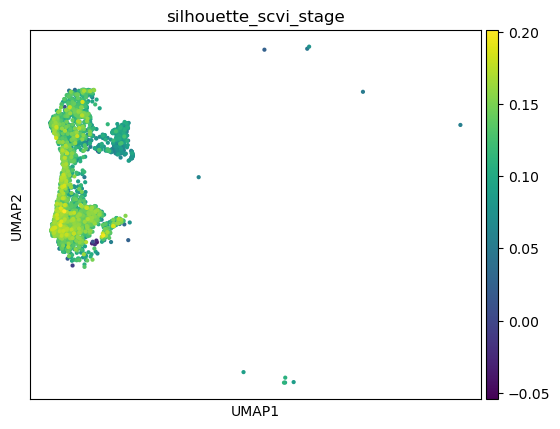

silhouette_scvi_stage  False  True 
compartment                        
endo                     909     73
epi                     3278     18
mes                     2049    323
other                    751    191
working on stage E17


<timed exec>:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.0984403


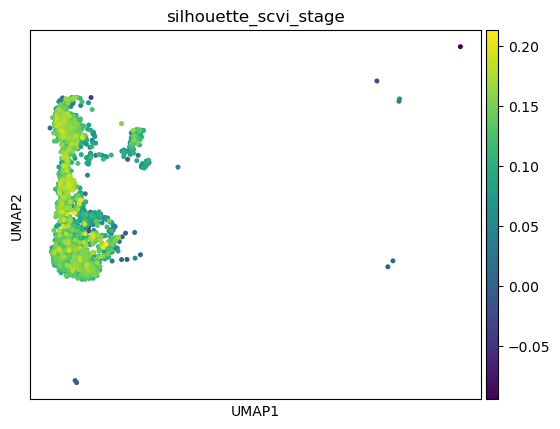

silhouette_scvi_stage  False  True 
compartment                        
endo                    1384     93
epi                     2297     19
mes                     1855     48
other                    700    195
working on stage P3


<timed exec>:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.10657064


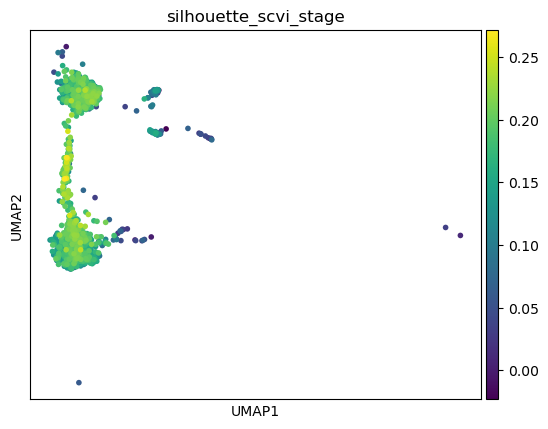

silhouette_scvi_stage  False  True 
compartment                        
endo                    2459     35
epi                     1816      7
mes                     4462    233
other                    113     17
working on stage P7


<timed exec>:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.093201965


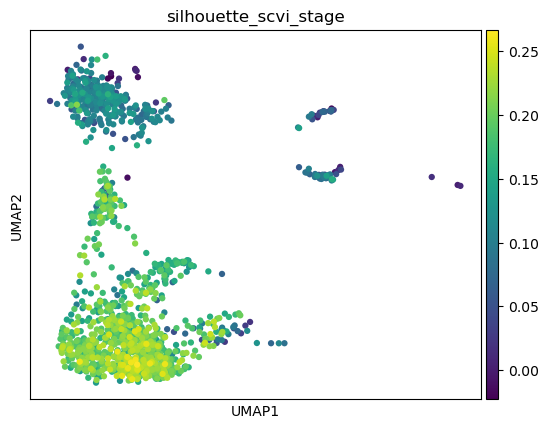

silhouette_scvi_stage  False  True 
compartment                        
endo                    3429     35
epi                     1448      9
mes                     4040    121
other                     99      8
working on stage P15


<timed exec>:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.111900024


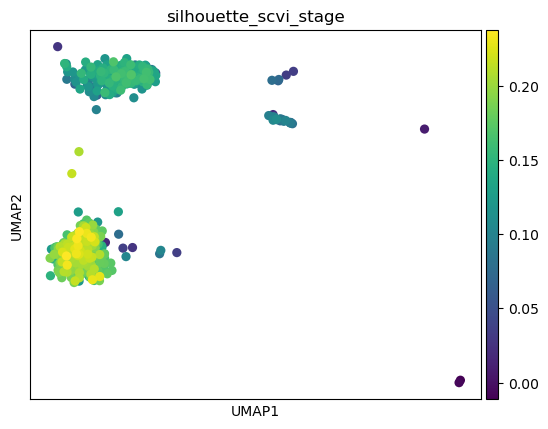

silhouette_scvi_stage  False  True 
compartment                        
endo                    6428     23
epi                      677      2
mes                     2075     38
other                     42     33
working on stage P42


<timed exec>:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.09637661


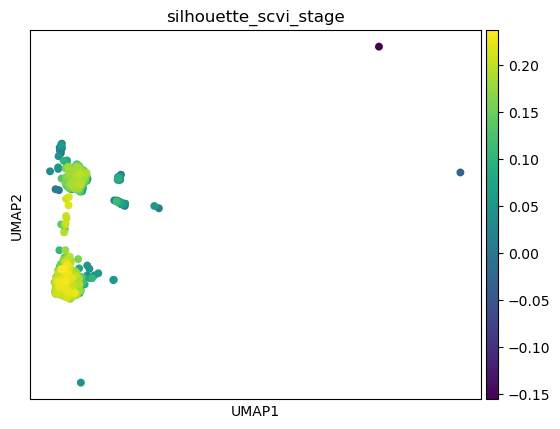

silhouette_scvi_stage  False  True 
compartment                        
endo                    6461     52
epi                      912     12
mes                     2719     45
other                     89     15
CPU times: user 30.4 s, sys: 35.2 s, total: 1min 5s
Wall time: 10.1 s


In [67]:
%%time
for stage in stages:
    print('working on stage',stage)

    stage_dat = dat[dat.obs.development_stage==stage]
    silhouette = silhouette_samples(stage_dat.obsm['X_scVI'], stage_dat.obs[f'compartment'])
    
    dat.obs.loc[dat.obs.development_stage==stage, 'silhouette_scvi_stage'] = silhouette
    stage_dat.obs['silhouette_scvi_stage'] = silhouette
    print(silhouette.mean())
    
    sc.pl.umap(stage_dat[(stage_dat.obs.compartment==comp) ], color=['silhouette_scvi_stage'])
    print(pd.crosstab(stage_dat.obs.compartment, stage_dat.obs.silhouette_scvi_stage<0))


0.015289600333198905

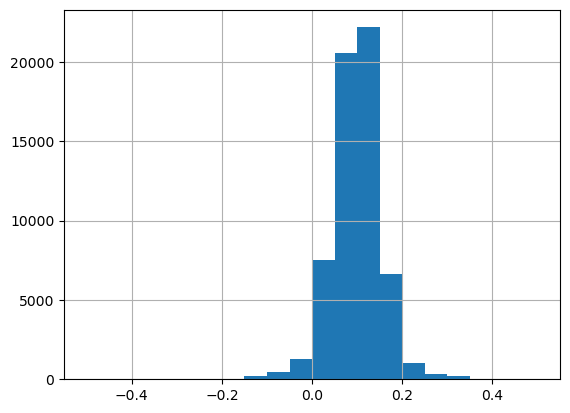

In [68]:
dat.obs.silhouette_scvi_stage.hist(bins=np.linspace(-0.5,0.5,21))
np.percentile(dat.obs.silhouette_scvi_stage, 5)

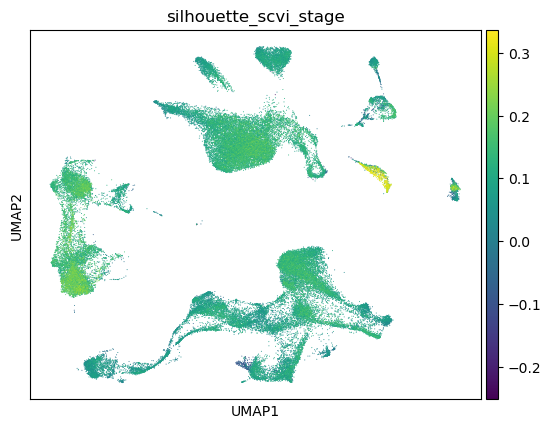

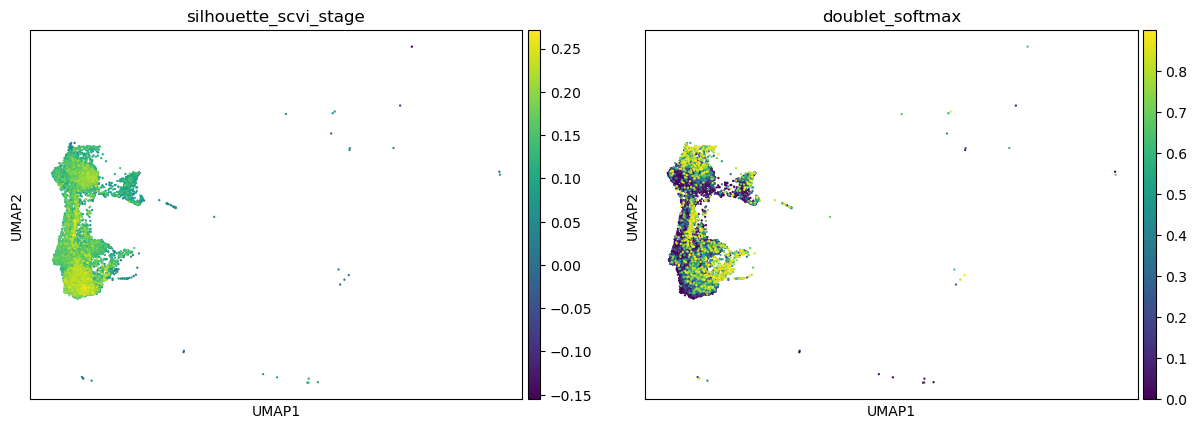

In [69]:
sc.pl.umap(dat, color=['silhouette_scvi_stage'])
sc.pl.umap(dat[(dat.obs.compartment==comp) ], color=['silhouette_scvi_stage', 'doublet_softmax'])

In [70]:
dat2 = dat[dat.obs.silhouette_scvi_stage > np.percentile(dat.obs.silhouette_scvi_stage, 5)]

In [71]:
dat3 = dat2[(dat2.obs.celltype != 'unknown3') & (dat2.obs.compartment=='epi')]
dat3.obs.celltype.value_counts()

celltype
AT2               3514
epi progenitor    3461
AT1               3095
Club               808
Ciliated            18
Name: count, dtype: int64

E12


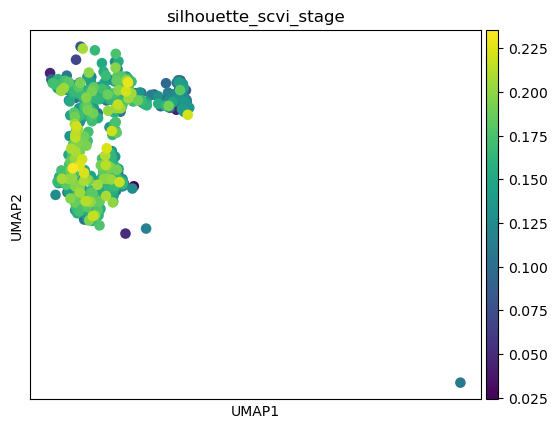

E15


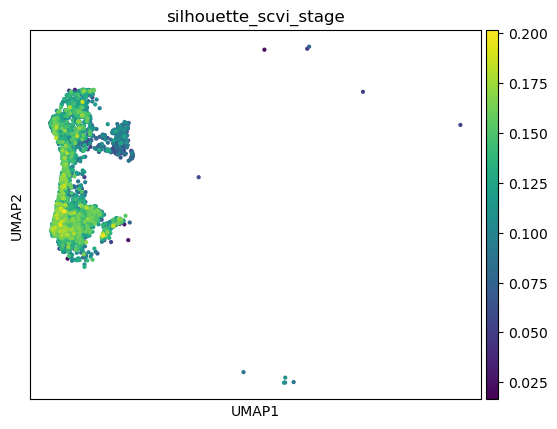

E17


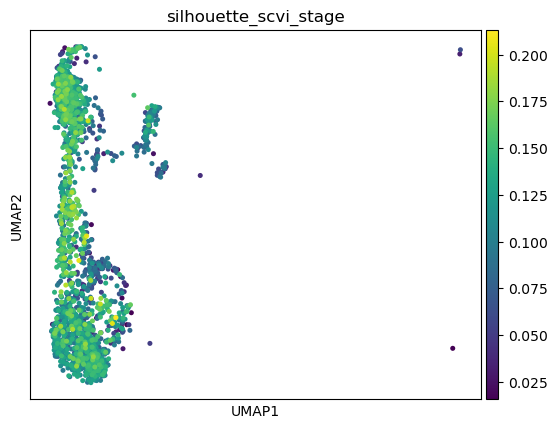

P3


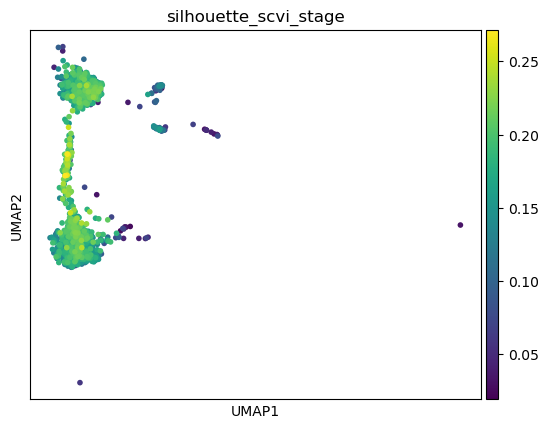

P7


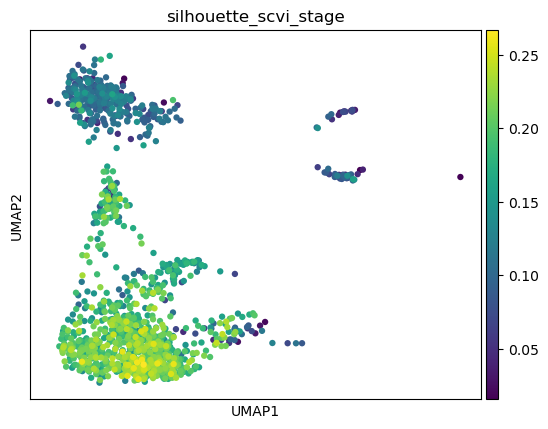

P15


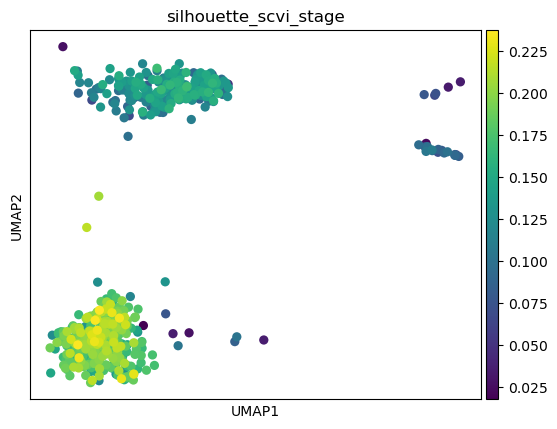

P42


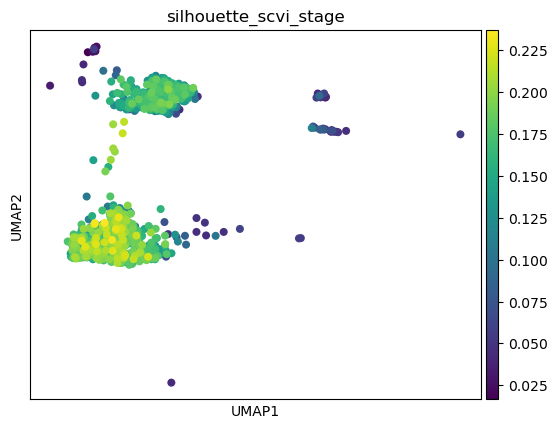

In [72]:
for stage in stages:
    print(stage)
    sc.pl.umap(dat3[dat3.obs.development_stage==stage], color=['silhouette_scvi_stage'])

In [74]:
adata = adata[dat2.obs_names]
adata

View of AnnData object with n_obs × n_vars = 57324 × 16964
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'doublet_softmax', 'doublet', 'doublet_softmax_r2'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'development_stage_max_var_norm', 'joint_highly_variable'
    uns: 'development_stage_colors', 'compartment_colors', 'celltype_colors', 'development_stage_colors_dict', 'compartment_colors_dict', 'celltype_colors_dict', 'hvg', 'neighbors', 'doublet_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_scVI'
    obsp: 'distances', 'connectivities'

### Saving/loading the pre-processed object

In [75]:
%%time
pre_processed_adata_file = results_dir.joinpath('full.h5ad')

if not pre_processed_adata_file.exists():
    adata.write(pre_processed_adata_file)
else:
    adata = sc.read(pre_processed_adata_file)
adata

CPU times: user 696 ms, sys: 948 ms, total: 1.64 s
Wall time: 15.1 s


View of AnnData object with n_obs × n_vars = 57324 × 16964
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'doublet_softmax', 'doublet', 'doublet_softmax_r2'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'development_stage_max_var_norm', 'joint_highly_variable'
    uns: 'development_stage_colors', 'compartment_colors', 'celltype_colors', 'development_stage_colors_dict', 'compartment_colors_dict', 'celltype_colors_dict', 'hvg', 'neighbors', 'doublet_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_scVI'
    obsp: 'distances', 'connectivities'

In [77]:
pd.crosstab(adata.obs.celltype, adata.obs.development_stage)

development_stage   E12   E15  E17    P3    P7   P15   P42
celltype                                                  
AMP                 144   184  287   260   281   158   308
ASM_SCMF            647   208  389   482  1821   329   213
AT1                 111   616  723   780   302   239   324
AT2                  49   239  732   781   805   404   504
Cap EC               47   514  724  1406  1897  4786  4280
Car4 EC               0     0   30   313   423   866   994
Ciliated              0     0    2    13     1     0     2
Club                101   364  146    81    60    24    32
Erythroid             0   552    4     0    38    35     0
Immune               61   144  663     1     0     0    27
Lymphatic EC         11    21   11    74    63   101   141
MANC                699    73   68   192   155   172   366
Mesothelial         152    19    1   112    61     6    55
VSM                  55    54   81   178   244   211   157
Wnt2-pa              45    82  780  3050   802  1182  1606
epi progenitor      257  2047  682   158   269     9    39
macro EC Arterial     0    15   86   207   228   361   544
macro EC Venous       0    38   59   154   242   254   390
mes progenitor     2867  1003  127    66   274     2    20
prolif EC            42   308  456   273   558    34    24
prolif mes         2211   394   79    56   254     0     0
tracheal mes        202     0    0     3     0     1     0

## 3. Subsetting and splitting the dataset by stage, and selecting joint highly variable genes (HVG)


### Splitting the adata by "development_stage", retaining only epithelial cells and creating a normalized variance layer

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector

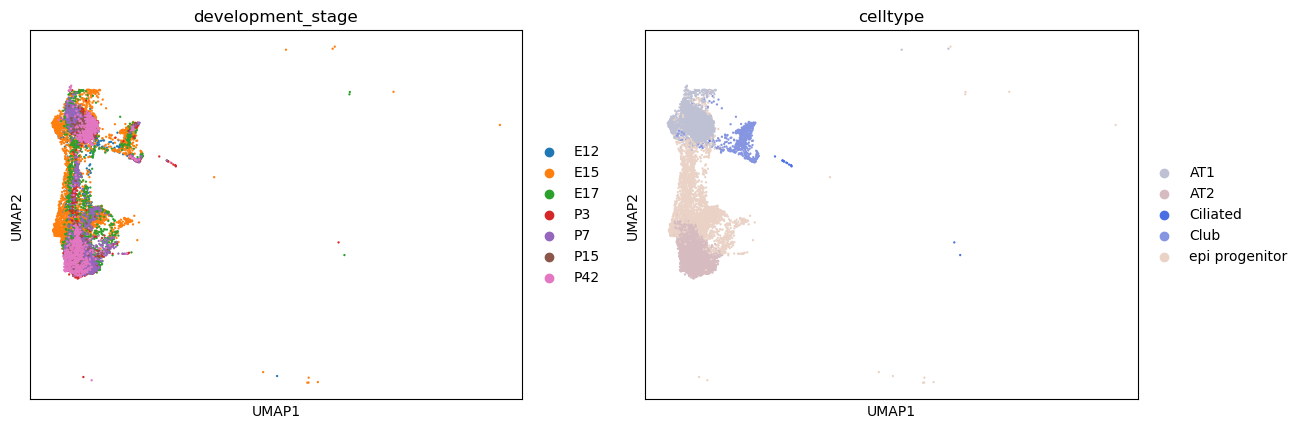

<timed exec>:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


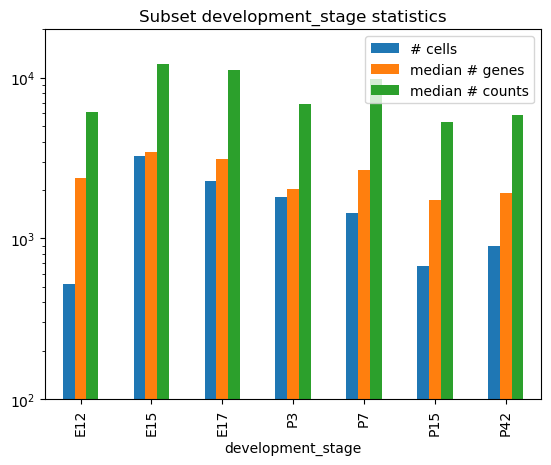

CPU times: user 7.53 s, sys: 1.63 s, total: 9.16 s
Wall time: 8.54 s


AnnData object with n_obs × n_vars = 10896 × 16875
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'doublet_softmax', 'doublet', 'doublet_softmax_r2'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'development_stage_max_var_norm', 'joint_highly_variable'
    uns: 'development_stage_colors', 'compartment_colors', 'celltype_colors', 'development_stage_colors_dict', 'compartment_colors_dict', 'celltype_colors_dict', 'hvg', 'neighbors', 'doublet_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_scVI'
    obsp: 'distances', 'connectivities'

In [76]:
%%time

column_of_interest = 'development_stage'

subset_adata_file = results_dir.joinpath('epi_subset.h5ad')

if not subset_adata_file.exists():
    subset = adata[adata.obs.compartment == 'epi'].copy()

    sc.pp.filter_genes(subset, min_cells=1)
    sc.pp.filter_genes(subset, min_counts=1)

    _utils.joint_hvg_across_stages(subset, obs_category_key=column_of_interest, n_top_genes=5000)

    subset.write(subset_adata_file)
else:
    subset = sc.read(subset_adata_file)

# umap by celltype:
sc.pl.umap(subset, color=[column_of_interest, 'celltype'])

# statistics
stats_df = subset.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([subset.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'Subset {column_of_interest} statistics', log=True, ylim=((1e2, 2e4)))
plt.show()
del stats_df

subset

In [78]:
%%time

categories = subset.obs[column_of_interest].cat.categories

split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))

for cat in categories:
    if not split_adatas_dir.joinpath(f'{cat}.h5ad').exists():
        print(f'working on {cat}')
        tmp = subset[subset.obs[column_of_interest] == cat].copy()

        tmp.uns['name'] = f'{cat}'   # full name
        tmp.uns['sname'] = f'{cat[:3]}'  # short name, here it is the same

        # correcting the gene counts
        sc.pp.filter_genes(tmp, min_cells=0)
        sc.pp.filter_genes(tmp, min_counts=0)

        tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

        del tmp
    else:
        print(f'{cat} split adata exists')

Directory "results/zepp/split_development_stage" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/zepp/split_development_stage
working on E12
working on E15
working on E17
working on P3
working on P7
working on P15
working on P42
CPU times: user 2 s, sys: 328 ms, total: 2.32 s
Wall time: 14.1 s


## 4. Running consensus NMF iterations

In [109]:
cnmf_dir = _utils.set_dir(results_dir.joinpath('cnmf'))

Directory "results/zepp/cnmf" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/zepp/cnmf


In [110]:
%%time

ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    
    # Variance normalized version of the data
    X = _utils.subset_and_normalize_for_nmf(tmp)
    
    c_object.prepare(X, ks, n_iter=120, new_nmf_kwargs={
        'tol': _constants.NMF_TOLERANCE, 'beta_loss': 'kullback-leibler', 'max_iter': 1000})
    
    c_object.factorize(0, 1, gpu=True)
    
    c_object.combine()
    
    del tmp, X

Starting on E12, time is 12:45:08
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Starting on E15, time is 12:58:33
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Starting on E17, time is 13:37:38
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combinin

In [111]:
%%time
for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, cat)
    for thresh in [0.5, 0.4]:
        print(f'working on threshold {thresh}')
        c_object.k_selection_plot(density_threshold=thresh, nmf_refitting_iters=1000, 
                                  consensus_method='mean',
                                  close_fig=True, show_clustering=True, gpu=True)
        # printing the selected knee point
        df = cnmf.load_df_from_npz(c_object.paths['k_selection_stats_dt'] % c_object.convert_dt_to_str(thresh))
        pos = len(df) - 4
        for i in range(5):
            print(cnmf.find_knee_point(df.prediction_error[:pos + i], df.k_source[:pos + i]), end=", ")
        print()

Starting on E12, time is 15:04:43
working on threshold 0.5
5.0, 6.0, 6.0, 7.0, 7.0, 
working on threshold 0.4
5.0, 6.0, 6.0, 7.0, 7.0, 
Starting on E15, time is 15:06:29
working on threshold 0.5
5.0, 5.0, 5.0, 5.0, 6.0, 
working on threshold 0.4
5.0, 5.0, 5.0, 5.0, 6.0, 
Starting on E17, time is 15:08:52
working on threshold 0.5
4.0, 5.0, 5.0, 5.0, 6.0, 
working on threshold 0.4
4.0, 5.0, 5.0, 5.0, 6.0, 
Starting on P3, time is 15:10:50
working on threshold 0.5
4.0, 4.0, 4.0, 4.0, 5.0, 
working on threshold 0.4
4.0, 4.0, 4.0, 4.0, 5.0, 
Starting on P7, time is 15:12:37
working on threshold 0.5
4.0, 4.0, 4.0, 5.0, 5.0, 
working on threshold 0.4
4.0, 4.0, 4.0, 5.0, 5.0, 
Starting on P15, time is 15:14:31
working on threshold 0.5
4.0, 4.0, 4.0, 4.0, 4.0, 
working on threshold 0.4
4.0, 4.0, 4.0, 4.0, 4.0, 
Starting on P42, time is 15:16:15
working on threshold 0.5
4.0, 4.0, 4.0, 4.0, 4.0, 
working on threshold 0.4
4.0, 4.0, 4.0, 4.0, 4.0, 
CPU times: user 43min 11s, sys: 39min 20s, total: 

## 5. Selecting decomposition rank for cNMF using knee-point

In [112]:
thresh = 0.5
selected_cnmf_params = {}

for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, cat)

    df = cnmf.load_df_from_npz(c_object.paths['k_selection_stats_dt'] % c_object.convert_dt_to_str(thresh))
    pos = len(df) - 4
    for i in range(5):
        print(cnmf.find_knee_point(df.prediction_error[:pos + i], df.k_source[:pos + i]), end=", ")
    print()
    
    selected_cnmf_params[cat] = (int(cnmf.find_knee_point(df.prediction_error, df.k_source)), thresh)

selected_cnmf_params

Starting on E12, time is 15:56:17
5.0, 6.0, 6.0, 7.0, 7.0, 
Starting on E15, time is 15:56:17
5.0, 5.0, 5.0, 5.0, 6.0, 
Starting on E17, time is 15:56:17
4.0, 5.0, 5.0, 5.0, 6.0, 
Starting on P3, time is 15:56:17
4.0, 4.0, 4.0, 4.0, 5.0, 
Starting on P7, time is 15:56:17
4.0, 4.0, 4.0, 5.0, 5.0, 
Starting on P15, time is 15:56:17
4.0, 4.0, 4.0, 4.0, 4.0, 
Starting on P42, time is 15:56:17
4.0, 4.0, 4.0, 4.0, 4.0, 


{'E12': (7, 0.5),
 'E15': (6, 0.5),
 'E17': (6, 0.5),
 'P3': (5, 0.5),
 'P7': (5, 0.5),
 'P15': (4, 0.5),
 'P42': (4, 0.5)}

In [113]:
%%time

split_adatas = {}

for cat, (k, threshold) in selected_cnmf_params.items():
    print(f'Working on epi {cat} with k={k} and threshold={threshold}')
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                       consensus_method='mean',
                       nmf_refitting_iters=1000, show_clustering=False)

    usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)

    tmp.uns['cnmf_params'] = {'k_nmf': k, 'threshold': threshold}

    tmp.obsm['usages'] = usages.copy()

    usages_norm = usages / np.sum(usages, axis=1, keepdims=True)
    tmp.obsm['usages_norm'] = usages_norm

    # get per gene z-score of data after cp10k normalization and log1p transformation 
    tpm_log1p_zscore = tmp.X.toarray()
    tpm_log1p_zscore /= 1e-4 * np.sum(tpm_log1p_zscore, axis=1, keepdims=True)
    tpm_log1p_zscore = np.log1p(tpm_log1p_zscore)
    tpm_log1p_zscore = sc.pp.scale(tpm_log1p_zscore)

    usage_coefs = _utils.fastols(usages_norm, tpm_log1p_zscore)

    tmp.varm['usage_coefs'] = pd.DataFrame(
        usage_coefs.T, index=tmp.var.index,
        columns=[f'{tmp.uns["sname"]}.p{prog}' for prog in range(usages.shape[1])])
    
    split_adatas[cat] = tmp

    tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    print()

Working on epi E12 with k=7 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 917536.3125, # iterations was 160
Refitting W, H based on consensus
beta 1 loss = 910997.625, # iterations was 330

Working on epi E15 with k=6 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 6797026.0, # iterations was 120
Refitting W, H based on consensus
beta 1 loss = 6775233.5, # iterations was 190

Working on epi E17 with k=6 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 4796059.5, # iterations was 100
Refitting W, H based on consensus
beta 1 loss = 4794505.0, # iterations was 70

Working on epi P3 with k=5 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 3287387.0, # iterations was 80
Refitting W, H based on consensus
beta 1 loss = 3283654.0, # iterations was 70

Working on epi P7 with k=5 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 2991174.75, # iterations was 90
Refitting W, H based on cons

### Examining results

In [2]:
%%time

split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))

split_adatas = {}
for cat in categories:
    split_adatas[cat] = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

NameError: name 'split_adatas_dir' is not defined

In [114]:
for cat in categories:
    print(cat)
    s = split_adatas[cat].obsm['usages_norm'].sum(axis=0)
    with np.printoptions(precision=2, suppress=False):
        print(s * 100 / s.sum())

E12
[12.18 15.32  4.07 13.05 17.09 21.39 16.9 ]
E15
[12.16 15.31 10.91 32.1   2.06 27.45]
E17
[24.   31.51  7.48 29.17  6.32  1.52]
P3
[43.    2.79 46.45  4.25  3.51]
P7
[24.37  3.15 54.32  9.78  8.38]
P15
[ 3.5  34.53 50.39 11.58]
P42
[36.03 51.58  2.7   9.7 ]


In [116]:
decomposition_images = _utils.set_dir(split_adatas_dir.joinpath("images"))

with warnings.catch_warnings():  # supress scanpy plotting warning
    warnings.simplefilter(action='ignore', category=UserWarning)
    warnings.simplefilter(action='ignore', category=FutureWarning)

    for cat in categories:
        epidata = sc.read_h5ad(split_adatas_dir.joinpath(f"{cat}.h5ad"))

        # UMAP
        um = sc.pl.umap(epidata, color='celltype', s=10, return_fig=True, title=f'{cat} epithelial')
        plt.tight_layout()
        um.savefig(decomposition_images.joinpath(f"epi_{cat}_umap_celltype.png"), dpi=300)
        plt.close(um)

        # usages clustermap
        un_sns = _utils.plot_usages_norm_clustermaps(
            epidata, title=f'{cat}', show=False,sns_clustermap_params={
                'row_colors': epidata.obs['celltype'].map(epidata.uns['celltype_colors_dict'])})
        un_sns.savefig(decomposition_images.joinpath(f"{cat}_usages_norm.png"),
                       dpi=180, bbox_inches='tight')
        plt.close(un_sns.fig)

        # usages violin plot
        _utils.plot_usages_norm_violin(
            epidata, 'celltype', save_path=decomposition_images.joinpath(
                f'{cat}_norm_usage_per_lineage.png'))

## 6. Running comparator on the data

In [2]:
%%time

column_of_interest = 'development_stage'
categories = ['E12', 'E15', 'E17', 'P3', 'P7', 'P15', 'P42']

results_dir = _utils.set_dir('results')
results_dir = _utils.set_dir(results_dir.joinpath('zepp'))

split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))


split_adatas = {}
for cat in categories:
    split_adatas[cat] = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

CPU times: user 874 ms, sys: 234 ms, total: 1.11 s
Wall time: 25.8 s


In [118]:
for cat in categories:
    tmp = split_adatas[cat]

    field_1 = 'celltype'

    tmp.obsm['row_colors'] = pd.concat([
        tmp.obs[field_1].map(tmp.uns[f'{field_1}_colors_dict']),
        ], axis=1)

In [ ]:
%%time

cnmf_dir = _utils.set_dir(results_dir.joinpath('cnmf'))
pairs = [(categories[i], categories[i + 1]) for i in range(len(categories) - 1)]

for cat_a, cat_b in pairs:
    print(f'comparing {cat_a} and {cat_b}')
    comparison_dir = _utils.set_dir(results_dir.joinpath(f"comparator_{cat_a}_{cat_b}"))
    
    adata_a = split_adatas[cat_a]
    adata_b = split_adatas[cat_b]
    
    # if os.path.exists(comparison_dir.joinpath('comparator.npz')):
    #     cmp = comparator.Comparator.load_from_file(comparison_dir.joinpath('comparator.npz'), adata_a, adata_b)
    # else:
    cmp = comparator.Comparator(adata_a, adata_a.obsm['usages'], adata_b, comparison_dir,
                                'torchnmf', device='cuda', max_nmf_iter=1000, verbosity=1,
                               highly_variable_genes='joint_highly_variable',
                               tpm_target_sum=10_000)

    print('decomposing')
    cmp.extract_geps_on_jointly_hvgs()
    
    # getting cnmf results
    c_object = cnmf.cNMF(cnmf_dir, cat_b)
    usages_matrices_b = []
    
    threshold = adata_b.uns['cnmf_params']['threshold']
    for k in range(cmp.rank_a, cmp.rank_a + cmp.max_added_rank + 1):
        try:
            usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
        except FileNotFoundError:
            print(f'Calculating consensus NMF for k={k} and threshold={threshold}')
            c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                               consensus_method='mean',
                               nmf_refitting_iters=1000, show_clustering=False)

            usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
        
        usages_matrices_b.append(usages)
    
    cmp.decompose_b(repeats = 5, precalculated_denovo_usage_matrices=usages_matrices_b)
    
    cmp.print_errors()
    
    cmp.examine_adata_a_decomposition_on_jointly_hvgs()
    cmp.examine_adata_b_decompositions()
    cmp.plot_decomposition_comparisons()
    
    cmp.calculate_fingerprints()
    
    print('running GSEA')
    cmp.run_gsea(gprofiler_kwargs=dict(organism='mmusculus', sources=['GO:BP', 'WP', 'REAC', 'KEGG']))

    cmp.save_to_file(comparison_dir.joinpath('comparator.npz'))



comparing E12 and E15
decomposing
Extracting A GEPs on jointly highly variable genes
trying to import torch
Decomposing B using A GEPs and no additional GEPs
beta 1 loss = 8478545.0, # iterations was 90
Decomposing B de-novo
Decomposing B de-novo, rank=7
Decomposing B de-novo, rank=8
Decomposing B de-novo, rank=9
Decomposing B de-novo, rank=10
Decomposing B using A GEPs and up to 3 additional GEPs
Working on added rank = 1
repeat 0, after 105 iterations reached error =  7011925.2
repeat 1, after 105 iterations reached error =  7011921.3
